# Imports

In [4]:
import pandas as pd
# For Data Visualisation
import matplotlib.pyplot as plt
from time import sleep, time
from urllib.error import HTTPError
# Reading the PDF by OCR - Preliminaries
import requests, io, pytesseract
import fitz as fz #PyMuPdf
from PIL import Image
import json, os
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# LLM initialization
import ollama
# For structured output schema
from pydantic import BaseModel

# DB Check and Updation

In [2]:
# Get the details of all devices
some_ret = pd.read_html("https://www.fda.gov/medical-devices/software-medical-device-samd/artificial-intelligence-and-machine-learning-aiml-enabled-medical-devices")
dataframe = some_ret[0]

# Save the details
csvFileName = "FDA_DB.csv"
stored_DF = pd.read_csv(csvFileName, index_col=None)

# Check for differences
new_indices = []
for val in dataframe["Submission Number"].values:
    if val not in stored_DF["Submission Number"].values:
        new_indices.append(stored_DF["Submission Number"][stored_DF["Submission Number"] == val].index)
if len(new_indices) == 0:
    print("No difference...")
else:
    # TODO: Write only these lines to the DB
    dataframe.to_csv(csvFileName, index=False)

# Read the details
stored_DF = pd.read_csv(csvFileName, index_col=None)

# Extracting the details of Pre-Market approved, Radiology devices alone
required_data = stored_DF.loc[stored_DF["Panel (lead)"] == "Radiology"]
required_data = required_data[required_data["Submission Number"].str.contains("K") == True]
required_data.reset_index(inplace=True)
required_data = required_data.drop("index", axis=1)

No difference...


# Data Analysis

In [3]:
stored_DF.head()

,Date of Final Decision,Submission Number,Device,Company,Panel (lead),Primary Product Code
0,5/30/2025,K251406,BriefCase-Triage,"Aidoc Medical, Ltd.",Radiology,QAS
1,5/30/2025,K250236,Swoop® Portable MR Imaging® System (V2),"Hyperfine, Inc.",Radiology,LNH
2,5/30/2025,K243863,Opulus™ Lymphoma Precision,Roche Molecular System,Radiology,QIH
3,5/30/2025,K243005,AudaxCeph Cephalogram Analysis Software,Audax d.o.o.,Radiology,QIH
4,5/30/2025,K242830,LensHooke X3 PRO Semen Quality Analyzer; LensH...,"Bonraybio Co., LTD.",Hematology,POV


In [6]:
category_counts = stored_DF["Panel (lead)"].value_counts()

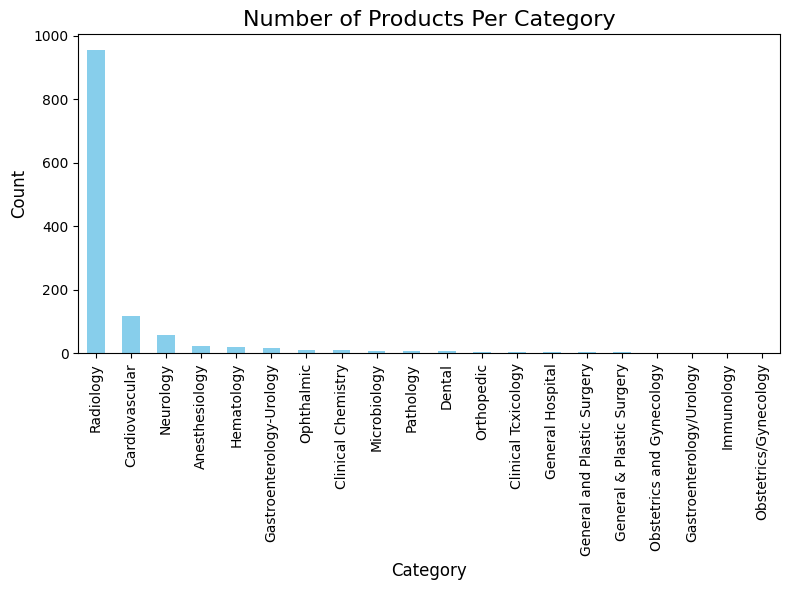

In [14]:
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Products Per Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
# Approval type of the radiological products
stored_DF.loc[stored_DF["Panel (lead)"] == "Radiology"]["Submission Number"].str[0].str.lower().value_counts()
# K - 510k premarket notification
# D - Denovo classification 513(f)(2)(De Novo)
# P - Premarket Approval

Submission Number
k    940
d      8
p      8
Name: count, dtype: int64

# Scraping PDF URLs

In [4]:
device_name = "Annalise Enterprise CTB Triage"
required_FDA_doc_idx = [idx for idx, device in enumerate(required_data["Device"]) if device_name in device]

In [5]:
# Script to scrape pdf URL data for particular device IDs and save them to a text file
pdf_urls = []
sleep_time_recommended = 25 # in seconds --> from robots.txt
file_with_URLs = "pdf_urls.txt"
for doc_id in required_FDA_doc_idx[1:]:
    try:
        device_ID = required_data["Submission Number"][doc_id]
        specific_device_FDA_URL = f"https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfPMN/pmn.cfm?ID={device_ID}"
        some_ret = pd.read_html(specific_device_FDA_URL) # Pandas DataFrame object
        # For single digit years its just single digit -> 4 not 04
        year_submitted = str(int(some_ret[7].loc[some_ret[7][0] == "Date Received"][1].values[0][-2:]))
        pdf_URL = f"https://www.accessdata.fda.gov/cdrh_docs/pdf{year_submitted}/{device_ID}.pdf"
        pdf_urls.append(pdf_URL)
        print(f"Finished device with ID: {doc_id}...")
        if doc_id != required_FDA_doc_idx[-1]:
            sleep(sleep_time_recommended)
    except HTTPError:
        print(HTTPError)
with open(file_with_URLs, "a") as f:
    for i in range(len(pdf_urls)):
        f.write(pdf_urls[i]+"\n")

Finished device with ID: 368...
Finished device with ID: 381...
Finished device with ID: 436...


In [37]:
# Script to scrape pdf URL data and save them to a text file
pdf_urls = []
sleep_time_recommended = 25 # in seconds --> from robots.txt
devices_already_done = 4 # Done 29 --> Start from 29 for next batch
devices_needed_currently = 17
file_with_URLs = "pdf_urls.txt"
for i in range(devices_already_done, devices_already_done+devices_needed_currently):
    try:
        sleep(sleep_time_recommended)
        device_ID = required_data["Submission Number"][i]
        specific_device_FDA_URL = f"https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfPMN/pmn.cfm?ID={device_ID}"
        some_ret = pd.read_html(specific_device_FDA_URL) # Pandas DataFrame object
        # For single digit years its just single digit -> 4 not 04
        year_submitted = str(int(some_ret[7].loc[some_ret[7][0] == "Date Received"][1].values[0][-2:]))
        pdf_URL = f"https://www.accessdata.fda.gov/cdrh_docs/pdf{year_submitted}/{device_ID}.pdf"
        pdf_urls.append(pdf_URL)
        print(f"Finished device {i+1}...")
        if not ((i+1)%5):
            with open(file_with_URLs, "a") as f:
                for i in range(len(pdf_urls)):
                    f.write(pdf_urls[i]+"\n")
            pdf_urls = []
    except HTTPError:
        print(HTTPError)
with open(file_with_URLs, "a") as f:
    for i in range(len(pdf_urls)):
        f.write(pdf_urls[i]+"\n")

Finished device 5...
Finished device 6...
Finished device 7...
Finished device 8...
Finished device 9...
Finished device 10...
Finished device 11...
Finished device 12...
Finished device 13...
Finished device 14...
Finished device 15...
Finished device 16...
Finished device 17...
Finished device 18...
Finished device 19...
Finished device 20...
Finished device 21...


In [ ]:
f"https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfPMN/pmn.cfm?ID={device_ID}" # DeNovo Approval

'https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfPMN/pmn.cfm?ID=DEN240047'

# PDF Reader

## Associated Code

In [2]:
from PyPDF2 import PdfReader

In [3]:
# file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf24/K240369.pdf" # BunkerHillHealth
# file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf21/K212365.pdf" # BoneViewer
def get_pdf_data(file_URL:str) -> list[str]:
    """Pass file URL to get the contents of the document"""
    response = requests.get(url=file_URL)
    on_fly_mem_obj = io.BytesIO(response.content)
    pdf_file = PdfReader(on_fly_mem_obj)
    # doc = fz.open(stream=on_fly_mem_obj, filetype="pdf") # Better than PdfReader
    doc_info = [f"\n--- Page{i+1} ---\n"+pdf_file.pages[i].extract_text() for i in range(len(pdf_file.pages))]
    return doc_info
def remove_letter_page(doc_info:list) -> list[str]:
    """Removes the obligatory letter page from the FDA"""
    letter_pages = []
    for page in doc_info:
        if ("enclosure" in page.lower()) or ("sincerely" in page.lower()):
            letter_pages.append(doc_info.index(page))
    if letter_pages[0] == 0:
        return doc_info[letter_pages[-1]+1:]
    else:
        return doc_info[:letter_pages[0]] + doc_info[letter_pages[-1]+1:]

In [71]:
file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf8/K080762.pdf" # IB Neuro
file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf21/K212365.pdf" # BoneView - Gleamer
doc_info = remove_letter_page(get_pdf_data(file_URL))

In [73]:
print(*doc_info)


--- Page3 ---
K212365
BoneView
BoneView is intended to analyze radiographs using machine learning techniques to identify and highlight 
fractures during the review of radiographs of:
BoneView is intended for use as a concurrent reading aid during the interpretations of radiographs. BoneView is 
for prescription use only and is indicated for adults only.
XStudy Type (Anatomical Area ofInterest) Compatible Radiographic View(s)
Ankle Frontal, Lateral, Oblique
Foot Frontal, Lateral, Oblique
Knee Frontal, Lateral
Tibia/Fibula Frontal, Lateral
Femur Frontal, Lateral
Wrist Frontal, Lateral, Oblique
Hand Frontal, Oblique
Elbow Frontal, Lateral
Forearm Frontal, Lateral
Humerus Frontal, Lateral
Shoulder Frontal, Lateral, Axillary
Clavicle Frontal
Pelvis Frontal
Hip Frontal, Frog LegLateral
Ribs Frontal Chest, Ribseries
Thoracic Spine Frontal, Lateral
Lumbosacral Spine Frontal, Lateral 
--- Page4 ---
BoneView® 510(k) Summary  
Page 1 
GLEAMER  
5 avenue du Général de Gaulle, 94160 Saint -Mandé -

## Sample Testing (Current + Previous)

In [3]:
# data_check_URL = "https://www.ajnr.org/content/ajnr/early/2024/05/28/ajnr.A8358.full.pdf"

# For generation
file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231094.pdf"
data_check_URL = file_URL

# For example
file_URL_ex = "https://www.accessdata.fda.gov/cdrh_docs/pdf24/K240369.pdf"
data_check_URL_ex = file_URL_ex

In [5]:
response = requests.get(url=data_check_URL)
on_fly_mem_obj = io.BytesIO(response.content)
pdf_file = PdfReader(on_fly_mem_obj)
# doc = fz.open(stream=on_fly_mem_obj, filetype="pdf") # Better than PdfReader
doc_info = [f"\n--- Page{i+1} ---\n"+pdf_file.pages[i].extract_text() for i in range(len(pdf_file.pages))]

In [16]:
# For example
response_ex = requests.get(url=data_check_URL_ex)
on_fly_mem_obj_ex = io.BytesIO(response_ex.content)
pdf_file_ex = PdfReader(on_fly_mem_obj_ex)
# doc_ex = fz.open(stream=on_fly_mem_obj_ex, filetype="pdf") # Better than PdfReader
doc_info_ex = [f"\n--- Page{i+1} ---\n"+pdf_file_ex.pages[i].extract_text() for i in range(len(pdf_file_ex.pages))]
# print(*doc_info_ex)

In [ ]:
for page in doc.pages():
    print(page.get_text())

Annalise-AI Pty Ltd. 
℅ Haylee Bosshard 
Regulatory Affairs Manager 
Level P, 24 Campbell Street 
Sydney, New South Wales 2000 
AUSTRALIA 
Re:  K231094 
Trade/Device Name:  Annalise Enterprise CTB Triage-OH 
Regulation Number:  21 CFR 892.2080 
Regulation Name:  Radiological computer aided triage and notification software 
Regulatory Class:  Class II 
Product Code:  QAS 
Dated:  July 19, 2023 
Received:  July 19, 2023 
Dear Haylee Bosshard: 
We have reviewed your Section 510(k) premarket notification of intent to market the device referenced 
above and have determined the device is substantially equivalent (for the indications for use stated in the 
enclosure) to legally marketed predicate devices marketed in interstate commerce prior to May 28, 1976, the 
enactment date of the Medical Device Amendments, or to devices that have been reclassified in accordance 
with the provisions of the Federal Food, Drug, and Cosmetic Act (Act) that do not require approval of a 
premarket approval app

In [ ]:
# Testing
i = 0
for page in doc.pages():
    i += 1
    if i == 11:
        print(page.get_text())

 
 
 
 
Page 7 
 
VIII. CONCLUSIONS  
The subject device and the predicate device are both software only packages, devices intended to 
assist with worklist triage by providing notification of findings. The subject and predicate devices 
utilize the same principles of operation and work in parallel to the current standard of care workflow. 
Both the subject and predicate devices use an artificial intelligence algorithm to identify findings in 
images and require the same inputs (DICOM image data) and provide the same outputs (prioritization 
for a medical worklist).  
The technological differences between the subject and predicate devices do not raise new questions of 
safety and effectiveness.  
Standalone performance testing and the comparison of technological characteristics with the predicate 
devices shows that the subject device: 
 performs as intended,  
 is safe and effective for its intended use, and 
 is therefore substantially equivalent to the predicate device. 
 



In [35]:
# Paper 2
pdf_file_paper_2 = PdfReader("C:/Users/Thala/Downloads/s00330-023-10074-8.pdf")
doc_info_paper_2 = [f"\n--- Page{i+1} ---\n"+pdf_file_paper_2.pages[i].extract_text() for i in range(len(pdf_file_paper_2.pages))]
pages_not_needed_paper_2 = [6, 12, 13]#[5, 6, 8, 9, 10, 13]
doc_info_paper_2 = [doc_info_paper_2[page] for page in range(len(doc_info_paper_2)) if page+1 not in pages_not_needed_paper_2]
doc_info_paper_2

['\n--- Page1 ---\nVol:.(1234567890)European Radiology (2024) 34:810–822\nhttps://doi.org/10.1007/s00330-023-10074-8\n1 3\nCOMPUTED TOMOGRAPHY \nEffects of\xa0a\xa0comprehensive brain computed tomography deep \nlearning model on\xa0radiologist detection accuracy\nQuinlan\xa0D.\xa0Buchlak1,2,3 \xa0· Cyril\xa0H.\xa0M.\xa0Tang1\xa0· Jarrel\xa0C.\xa0Y .\xa0Seah1,4\xa0· Andrew\xa0Johnson1\xa0· Xavier\xa0Holt1\xa0· \nGeorgina\xa0M.\xa0Bottrell1\xa0· Jeffrey\xa0B.\xa0Wardman1\xa0· Gihan\xa0Samarasinghe1\xa0· Leonardo\xa0Dos\xa0Santos\xa0Pinheiro1\xa0· Hongze\xa0Xia1\xa0· \nHassan\xa0K.\xa0Ahmad1\xa0· Hung\xa0Pham1,5\xa0· Jason\xa0I.\xa0Chiang1,6,7\xa0· Nalan\xa0Ektas1\xa0· Michael\xa0R.\xa0Milne1\xa0· Christopher\xa0H.\xa0Y .\xa0Chiu1\xa0· \nBen\xa0Hachey1\xa0· Melissa\xa0K.\xa0Ryan1\xa0· Benjamin\xa0P .\xa0Johnston1\xa0· Nazanin\xa0Esmaili2,8\xa0· Christine\xa0Bennett2\xa0· \nTony\xa0Goldschlager3,9\xa0· Jonathan\xa0Hall1,10,11\xa0· Duc\xa0Tan\xa0Vo5\xa0· Lauren\xa0Oakden‑Rayner12\xa0· Jean‑

In [ ]:
# Paper 3
pdf_file_paper_3 = PdfReader("C:/Users/Thala/Downloads/hillis-et-al-evaluation-of-an-artificial-intelligence-model-for-identification-of-intracranial-hemorrhage-subtypes-on.pdf")
doc_info_paper_3 = [f"\n--- Page{i+1} ---\n"+pdf_file_paper_3.pages[i].extract_text() for i in range(len(pdf_file_paper_3.pages))]
pages_not_needed_paper_3 = [5, 6, 8, 9, 10, 13]
doc_info_paper_3 = [doc_info_paper_3[page] for page in range(len(doc_info_paper_3)) if page+1 not in pages_not_needed_paper_3]
doc_info_paper_3

['\n--- Page1 ---\nStroke: Vascular and Interventional Neurology\nORIGINAL RESEARCH\nEvaluation of an Artiﬁcial Intelligence Model\nfor Identiﬁcation of Intracranial Hemorrhage\nSubtypes on Computed Tomography of the\nHead\nJames M. Hillis, MBBS, DPhil†; Bernardo C. Bizzo, MD, PhD†; Isabella Newbury-Chaet;\nSarah F. Mercaldo, PhD; John K. Chin, MD; Ankita Ghatak, MSc; Madeleine A. Halle; Eric L’Italien;\nAshley L. MacDonald; Alex S. Schultz; Karen Buch, MD; John Conklin, MD; Stuart Pomerantz, MD;\nSandra Rincon, MD; Keith J. Dreyer, DO, PhD; William A. Mehan, MD, MBA\nBACKGROUND: Intracranial hemorrhage is a critical ﬁnding on computed tomography (CT) of the head. This study compared the\naccuracy of an artiﬁcial intelligence (AI) model (Annalise Enterprise CTB Triage Trauma) to consensus neuroradiologist interpre-\ntations in detecting 4 hemorrhage subtypes: acute subdural/epidural hematoma, acute subarachnoid hemorrhage, intra-axial\nhemorrhage, and intraventricular hemorrhage.\nMETH

In [61]:
# doc[6].get_text("dict")["blocks"][4]["lines"][0]["spans"][0]["text"]
page_num = 7
page_considered = doc[page_num].get_text("dict")["blocks"]
text_in_block = []
for block_num in range(len(page_considered)):
    block_considered = page_considered[block_num]["lines"]
    for line_num in range(len(block_considered)):
        line_considered = block_considered[line_num]["spans"]
        text_in_block.append([line_considered[span_num]["text"] for span_num in range(len(line_considered))])

In [6]:
doc_info = [f"\n--- Page{i+1} ---\n"+pdf_file.pages[i].extract_text() for i in range(len(pdf_file.pages))]

In [8]:
print("".join(doc_info))


--- Page1 ---
of July 16, 2025.This information is current asedema on computed tomography of the headfor identification of mass effect and vasogenic Evaluation of an artificial intelligence model
and James M. HillisBizzo Pomerantz, Sandra Rincon, Keith J. Dreyer, Bernardo C. Karen Buch, John Conklin, William A. Mehan, StuartAnkita Ghatak, Madeleine A. Halle, Ashley L. MacDonald, Isabella Newbury-Chaet, Sarah F. Mercaldo, John K. Chin,
http://www.ajnr.org/content/early/2024/05/28/ajnr.A8358 published online 28 May 2024 AJNR Am J Neuroradiol 
--- Page2 ---
This preprint represents the accepted version of the article and also includes the supplemental material; it differs from the printed version 
of the article. 
1  
Copyright 2024 by American Society of Neuroradiology.  
ORIGINAL  RESEARCH  
  
Evaluation of an artificial intelligence model for 
identification of mass effect and vasogenic edema on 
computed tomography of the head 
Isabella Newbury-Chaet, Sarah F. Mercaldo, John K. Chin

# OCR

## Associated Code

In [38]:
def ocr_get_pdf_data(file_URL:str):
    """OCR to get the data from the PDF URL"""
    try:
        current_url = file_URL
        print(current_url)
        start_time = time()
        request = requests.get(current_url) # Request is made only here
        filestream = io.BytesIO(request.content)
        # OCR and reading the file contents
        doc = fz.open(stream=filestream, filetype="pdf")
        ocr_text = []
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            pix = page.get_pixmap(matrix=fz.Matrix(2,2))
            img = Image.open(io.BytesIO(pix.tobytes()))
            text = pytesseract.image_to_string(img)
            ocr_text.append(f"\n--- Page {page_num + 1} (OCR) ---\n" + text)
        doc.close()
        print(f"Finished Device in {time() - start_time}s")
        return ocr_text
    except HTTPError:
        print(HTTPError)

def remove_letter_page(doc_info:list) -> list[str]:
    """Removes the obligatory letter page from the FDA"""
    letter_pages = []
    for page in doc_info:
        if ("enclosure" in page.lower()) or ("sincerely" in page.lower()):
            letter_pages.append(doc_info.index(page))
    if letter_pages[0] == 0:
        return doc_info[letter_pages[-1]+1:]
    else:
        return doc_info[:letter_pages[0]] + doc_info[letter_pages[-1]+1:]

In [5]:
file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf24/K240369.pdf" # CAC Algorithm - Bunkerhill Health
file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf8/K080762.pdf" # IBNeuro - Imaging Biometrics
file_URL = "https://www.accessdata.fda.gov/cdrh_docs/pdf21/K212365.pdf" # BoneView - Gleamer
doc_info = remove_letter_page(ocr_get_pdf_data(file_URL))

https://www.accessdata.fda.gov/cdrh_docs/pdf21/K212365.pdf
Finished Device in 45.988510608673096s


In [7]:
doc_info

['\n--- Page 3 (OCR) ---\n \n\nDEPARTMENT OF HEALTH AND HUMAN SERVICES\nFood and Drug Administration\n\nIndications for Use\n\nForm Approved: OMB No. 0910-0120\nExpiration Date: 06/30/2023\nSee PRA Statement below.\n\n \n\n \n\n510(k) Number (if known)\nK212365\n\nDevice Name\n\n \n\nBoneView\n\n \n\nIndications for Use (Describe)\nBone View is intended to analyze radiographs using machine learning techniques to identify and highlight\nfractures during the review of radiographs of:\n\n \n\n‘Study Type (Anatomical Area of Interest) ‘Compatible Radiographic View(s)\n‘Ankle Frontal, Lateral, Oblique\nFoot Frontal, Lateral, Oblique\n\n \n\n \n\n \n\n \n\nKnee Frontal, Lateral\nTibia/Fibula Frontal, Lateral\nFemur Frontal, Lateral\nWrist Frontal, Lateral, Oblique\n\n \n\nHand Frontal, Oblique\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nElbow Frontal, Lateral\nForearm Frontal, Lateral\nHumerus Frontal, Lateral\nShoulder Frontal, Lateral, Axillary\nClavicle Frontal\n\nPelvis Fro

In [69]:
print(*doc_info)


--- Page 3 (OCR) ---
 

DEPARTMENT OF HEALTH AND HUMAN SERVICES
Food and Drug Administration

Indications for Use

Form Approved: OMB No. 0910-0120
Expiration Date: 06/30/2023
See PRA Statement below.

 

 

510(k) Number (if known)
K212365

Device Name

 

BoneView

 

Indications for Use (Describe)
Bone View is intended to analyze radiographs using machine learning techniques to identify and highlight
fractures during the review of radiographs of:

 

‘Study Type (Anatomical Area of Interest) ‘Compatible Radiographic View(s)
‘Ankle Frontal, Lateral, Oblique
Foot Frontal, Lateral, Oblique

 

 

 

 

Knee Frontal, Lateral
Tibia/Fibula Frontal, Lateral
Femur Frontal, Lateral
Wrist Frontal, Lateral, Oblique

 

Hand Frontal, Oblique

 

 

 

 

 

 

 

 

 

 

 

Elbow Frontal, Lateral
Forearm Frontal, Lateral
Humerus Frontal, Lateral
Shoulder Frontal, Lateral, Axillary
Clavicle Frontal

Pelvis Frontal

Hip Frontal, Frog Leg Lateral
Ribs Frontal Chest, Rib series
Thoracic Spine Fro

## OCR Previous Experimentation

In [40]:
import os
with open("pdf_urls.txt") as pdf_urls_file:
    pdf_urls = pdf_urls_file.readlines()

In [41]:
sleep_time_recommended = 28
devices_needed_currently = 29
devices_already_done = 21
# Create a directory to hold the scraped PDF data
if not os.path.exists("./test_pdfs"):
    print("Creating Test Directory...")
    os.mkdir("./test_pdfs")
# Actual OCR Implementation
for i in range(devices_already_done, devices_already_done+devices_needed_currently):
    data_check_URL = pdf_urls[i][:-1]
    try:
        current_url = data_check_URL # Skips the "\n" portion at the end of each line
        print(current_url)
        start_time = time()
        request = requests.get(current_url) # Request is made only here
        filestream = io.BytesIO(request.content)
        # OCR and reading the file contents
        doc = fz.open(stream=filestream, filetype="pdf")
        ocr_text = []
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            pix = page.get_pixmap(matrix=fz.Matrix(2,2))
            img = Image.open(io.BytesIO(pix.tobytes()))
            text = pytesseract.image_to_string(img)
            ocr_text.append(text)
        doc.close()
        # Writing to text files
        ocr_text = "".join(remove_letter_page(ocr_text))
        with open(f"./test_pdfs/pdf_{i+1}.txt", "w") as current_file:
            current_file.write(ocr_text)
        print(f"Finished Device {i}...")
        processing_time = time() - start_time
        if (i+1 != devices_needed_currently) and (processing_time < sleep_time_recommended):
            sleep(sleep_time_recommended - processing_time)
    except HTTPError:
        print(HTTPError)

https://www.accessdata.fda.gov/cdrh_docs/pdf24/K241684.pdf
Finished Device 21...
https://www.accessdata.fda.gov/cdrh_docs/pdf24/K241098.pdf
Finished Device 22...
https://www.accessdata.fda.gov/cdrh_docs/pdf24/K240290.pdf
Finished Device 23...
https://www.accessdata.fda.gov/cdrh_docs/pdf24/K241496.pdf
Finished Device 24...
https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231767.pdf
Finished Device 25...
https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231384.pdf
Finished Device 26...
https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231094.pdf
Finished Device 27...
https://www.accessdata.fda.gov/cdrh_docs/pdf22/K223240.pdf
Finished Device 28...
https://www.accessdata.fda.gov/cdrh_docs/pdf25/K251406.pdf
Finished Device 29...
https://www.accessdata.fda.gov/cdrh_docs/pdf25/K250236.pdf
Finished Device 30...
https://www.accessdata.fda.gov/cdrh_docs/pdf24/K243863.pdf
Finished Device 31...
https://www.accessdata.fda.gov/cdrh_docs/pdf24/K243005.pdf
Finished Device 32...
https://www.accessdata.fda.g

## Prev.

In [17]:
print(ocr_texts[0])


--- Page 1 (OCR) ---
Taoyate Late OdaCe) (e<sMe MA /=) USI |) ee

CONTACT REP

 

AJNR

This information is current as
of July 15, 2025.

Evaluation of an artificial intelligence model
for identification of mass effect and vasogenic
edema on computed tomography of the head

Isabella Newbury-Chaet, Sarah F. Mercaldo, John K. Chin,
Ankita Ghatak, Madeleine A. Halle, Ashley L. MacDonald,
Karen Buch, John Conklin, William A. Mehan, Stuart
Pomerantz, Sandra Rincon, Keith J. Dreyer, Bernardo C. Bizzo
and James M. Hillis

AJNR Am J Neuroradiol published online 28 May 2024
http://www.ajnr.org/content/early/2024/05/28/ajnr.A8358

--- Page 2 (OCR) ---
This preprint represents the accepted MOUS HIP A MAY 28: 2028 B51 AS LEA AIN ABIES ic citters trom the printed version

of the article.

ORIGINAL RESEARCH

Evaluation of an artificial intelligence model for
identification of mass effect and vasogenic edema on
computed tomography of the head

Isabella Newbury-Chaet, Sarah F. Mercaldo, John K. Chin

In [ ]:
ocr_texts = []
# devices_needed_currently = 2
# for i in range(devices_already_done, devices_already_done+devices_needed_currently):
# for i in range(devices_needed_currently):
try:
    current_url = data_check_URL # Skips the "\n" portion at the end of each line
    print(current_url)
    start_time = time()
    request = requests.get(current_url) # Request is made only here
    filestream = io.BytesIO(request.content)
    # OCR and reading the file contents
    doc = fz.open(stream=filestream, filetype="pdf")
    ocr_text = ""
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        pix = page.get_pixmap(matrix=fz.Matrix(2,2))
        img = Image.open(io.BytesIO(pix.tobytes()))
        text = pytesseract.image_to_string(img)
        ocr_text += f"\n--- Page {page_num + 1} (OCR) ---\n" + text
    doc.close()
    ocr_texts.append(ocr_text)
    print(f"Finished Device...")
    processing_time = time() - start_time
    # if (i+1 != devices_needed_currently) and (processing_time < sleep_time_recommended):
    #     sleep(sleep_time_recommended - processing_time)
except HTTPError:
    print(HTTPError)

In [ ]:
# For the particular device IDs we need right now
# Read the file with the PDF URLs
file_with_URLs = "pdf_urls.txt"
sleep_time_recommended = 25

with open(file_with_URLs) as url_file:
    all_lines = url_file.readlines()

ocr_texts = []
# for i in range(devices_already_done, devices_already_done+devices_needed_currently):
for current_URL in all_lines[-2:]:
    try:
        current_url = current_URL[:-1] # Skips the "\n" portion at the end of each line
        print(current_url)
        start_time = time()
        request = requests.get(current_url) # Request is made only here
        filestream = io.BytesIO(request.content)
        # OCR and reading the file contents
        doc = fz.open(stream=filestream, filetype="pdf")
        ocr_text = ""
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            pix = page.get_pixmap(matrix=fz.Matrix(2,2))
            img = Image.open(io.BytesIO(pix.tobytes()))
            text = pytesseract.image_to_string(img)
            ocr_text += f"\n--- Page {page_num + 1} (OCR) ---\n" + text
        doc.close()
        ocr_texts.append(ocr_text)
        print(f"Finished Device...")
        processing_time = time() - start_time
        if (current_URL != all_lines[-1]) and (processing_time < sleep_time_recommended):
            sleep(sleep_time_recommended - processing_time)
    except HTTPError:
        print(HTTPError)

https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231767.pdf
Finished Device...
https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231384.pdf
Finished Device...
https://www.accessdata.fda.gov/cdrh_docs/pdf23/K231094.pdf
Finished Device...
https://www.accessdata.fda.gov/cdrh_docs/pdf22/K223240.pdf
Finished Device...


In [ ]:
# Read the file with the PDF URLs
with open(file_with_URLs) as url_file:
    all_lines = url_file.readlines()

ocr_texts = []
devices_needed_currently = 2
# for i in range(devices_already_done, devices_already_done+devices_needed_currently):
for i in range(devices_needed_currently):
    try:
        current_url = all_lines[i][:-1] # Skips the "\n" portion at the end of each line
        print(current_url)
        start_time = time()
        request = requests.get(current_url) # Request is made only here
        filestream = io.BytesIO(request.content)
        # OCR and reading the file contents
        doc = fz.open(stream=filestream, filetype="pdf")
        ocr_text = ""
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            pix = page.get_pixmap(matrix=fz.Matrix(2,2))
            img = Image.open(io.BytesIO(pix.tobytes()))
            text = pytesseract.image_to_string(img)
            ocr_text += f"\n--- Page {page_num + 1} (OCR) ---\n" + text
        doc.close()
        ocr_texts.append(ocr_text)
        print(f"Finished Device {i+1}")
        processing_time = time() - start_time
        if (i+1 != devices_needed_currently) and (processing_time < sleep_time_recommended):
            sleep(sleep_time_recommended - processing_time)
    except HTTPError:
        print(HTTPError)

https://www.accessdata.fda.gov/cdrh_docs/pdf24/K240369.pdf
Finished Device 1
https://www.accessdata.fda.gov/cdrh_docs/pdf24/K241480.pdf
Finished Device 2


# HTML Parser Part

In [10]:
GT_check_data_1 = requests.get("https://annalise.ai/evidence/effects-of-a-comprehensive-brain-computed-tomography-deep-learning-model-on-radiologist-detection-accuracy/")
GT_check_data_2 = requests.get("https://annalise.ai/evidence/urgent-vs-non-urgent-triage-of-ctb-based-on-a-comprehensive-ai-model-validation-on-a-ground-truthed-real-world-dataset/")

In [11]:
from html.parser import HTMLParser
data_parts = []
class MyHTMLParser(HTMLParser):
    def __init__(self, *, convert_charrefs = True):
        super().__init__(convert_charrefs=convert_charrefs)
        self.startTag = None

    def handle_starttag(self, tag, attrs):
        if tag == "p":
            self.startTag = tag

    def handle_endtag(self, tag):
        if tag == self.startTag:
            self.startTag = None
            # print("Encountered an end tag :", tag)

    def handle_data(self, data):
        if self.startTag == "p":
            global data_parts
            data_parts.append(data)
customHTMLParser = MyHTMLParser()
customHTMLParser.feed(GT_check_data_1.text)
data_parts = data_parts[3:-23]
customHTMLParser.feed(GT_check_data_2.text)
data_parts = data_parts[:-23]
# print("\n".join(data_parts[3:-24])) # Excluding the authors and other company information

In [ ]:
data_parts[:-23] # Data from 2nd article

['Brotchie, Peter Rodney | St. Vincent’s Hospital, Australia / annalise.ai',
 'Scientific presentation (',
 'W3-SSNR11-4',
 ') at RSNA 2023, 26 – 30. November 2023 in Chicago, US',
 'Purpose',
 ':',
 'Can a single output score effectively distinguish urgent from non-urgent cases on non-contrast head CT studies?',
 'Method',
 ':',
 'Post-processing of AI model (Annalise Enterprise CTB) output into a single score, with 51/130 findings included as urgent. 2,807 non-contrast head CT cases were included, ground-truthed by consultant radiologists. Bootstrapping method on 2,000 cases with 12.5% prevalence of urgent findings was performed at different thresholds for non-urgent predictions (25%, 40%, 50%).',
 'Results:',
 'The post-processed output achieved an AUC of 0.92 on the overall dataset (42% urgent cases). On sampled datasets for 50, 40, and 25% non-urgent thresholds, sensitivity was 0.97 – 0.99, specificity was 0.40 – 0.18, with 7 – 1 false negatives.',
 'Conclusion:',
 'Single score p

In [ ]:
print("\n".join(data_parts[3:-23])) # Excluding the authors and other company information - Data from 1st article

Non-contrast computed tomography of the brain (NCCTB) is commonly used to detect intracranial pathology but is subject to interpretation errors. Machine learning can augment clinical decision-making and improve NCCTB scan interpretation. This retrospective detection accuracy study assessed the performance of radiologists assisted by a deep learning model and compared the standalone performance of the model with that of unassisted radiologists.
A deep learning model was trained on 212,484 NCCTB scans drawn from a private radiology group in Australia. Scans from inpatient, outpatient, and emergency settings were included. Scan inclusion criteria were age ≥ 18 years and series slice thickness ≤ 1.5 mm. Thirty-two radiologists reviewed 2848 scans with and without the assistance of the deep learning system and rated their confidence in the presence of each finding using a 7-point scale. Differences in AUC and Matthews correlation coefficient (MCC) were calculated using a ground-truth gold s

In [15]:
doc_info[1:6]

['\n--- Page2 ---\nThis preprint represents the accepted version of the article and also includes the supplemental material; it differs from the printed version \nof the article. \n1  \nCopyright 2024 by American Society of Neuroradiology.  \nORIGINAL  RESEARCH  \n  \nEvaluation of an artificial intelligence model for \nidentification of mass effect and vasogenic edema on \ncomputed tomography of the head \nIsabella Newbury-Chaet, Sarah F. Mercaldo, John K. Chin, Ankita Ghatak, Madeleine A. Halle, Ashley L. MacDonald, Karen Buch, \nJohn Conklin, William A. Mehan, Stuart Pomerantz, Sandra Rincon, Keith J. Dreyer, Bernardo C. Bizzo*, James M. Hillis* \n \n ABSTRACT  \nBACKGROUND AND PURPOSE:  Mass effect and vasogenic edema are critical findings on CT of the head. Th is study compared the \naccuracy of an artificial intelligence model (Annalise Enterprise CTB) to consensus neuroradiologist interpretations in detec ting mass \neffect and vasogenic edema.  \nMATERIALS AND METHODS: A retros

# Associated functions

In [20]:
def join_docs(article_parts, *papers_to_process) -> str:
    processed_docs = ""
    processed_docs += "\n".join(article_parts)
    if papers_to_process:
        for doc_considered in papers_to_process:
            processed_docs += "".join(doc_considered)
    return processed_docs

In [21]:
def get_answers(model:str, doc_contents:str, prompt:str, times_to_run:int = 5, temperature:float = 0):
    for i in range(times_to_run):
        if temperature == None:
            response = ollama.generate(model = model,
                        prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                        format = "json")
        else:
            response = ollama.generate(model = model,
                                    prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                                    format = "json",
                                    options = {"temperature": temperature})
        print(f"--- Response from time {i+1}: ---")
        print(response.response)

In [2]:
class ProductInfo(BaseModel):
    AI_Product_name:str
    AI_Company_name:str
    Sub_specialty:str
    Imaging_Modality:str
    Intended_Purpose:str
    Summary_passage_of_Clinical_use:str
    Summary_passage_of_Product_output:str
    CE_Classification:str
    FDA_Classification:str
    Manufacturer:str
details_schema = ProductInfo.model_json_schema() # Dict of JSON Schema

In [67]:
details_schema

{'properties': {'AI_Product_name': {'title': 'Ai Product Name',
   'type': 'string'},
  'AI_Company_name': {'title': 'Ai Company Name', 'type': 'string'},
  'Sub_specialty': {'title': 'Sub Specialty', 'type': 'string'},
  'Imaging_Modality': {'title': 'Imaging Modality', 'type': 'string'},
  'Intended_Purpose': {'title': 'Intended Purpose', 'type': 'string'},
  'Summary_passage_of_Clinical_use': {'title': 'Summary Passage Of Clinical Use',
   'type': 'string'},
  'Summary_passage_of_Product_output': {'title': 'Summary Passage Of Product Output',
   'type': 'string'},
  'CE_Classification': {'title': 'Ce Classification', 'type': 'string'},
  'FDA_Classification': {'title': 'Fda Classification', 'type': 'string'},
  'Manufacturer': {'title': 'Manufacturer', 'type': 'string'}},
 'required': ['AI_Product_name',
  'AI_Company_name',
  'Sub_specialty',
  'Imaging_Modality',
  'Intended_Purpose',
  'Summary_passage_of_Clinical_use',
  'Summary_passage_of_Product_output',
  'CE_Classification'

In [ ]:
list_of_regen_fields = ["AI_Product_name", "AI_Company_name", "Summary_passage_of_Clinical_use"]
new_details_schema = dict(details_schema)
new_details_schema["properties"] = {field_considered: new_details_schema["properties"][field_considered] for field_considered in list_of_regen_fields}
new_details_schema["required"] = list_of_regen_fields

{'properties': {'AI_Product_name': {'title': 'Ai Product Name',
   'type': 'string'},
  'AI_Company_name': {'title': 'Ai Company Name', 'type': 'string'},
  'Summary_passage_of_Clinical_use': {'title': 'Summary Passage Of Clinical Use',
   'type': 'string'}},
 'required': ['AI_Product_name',
  'AI_Company_name',
  'Summary_passage_of_Clinical_use'],
 'title': 'ProductInfo',
 'type': 'object'}

# Current Experimentation

## Some prelim prereq parts

In [3]:
doc_contents = "".join((ocr_texts[0].split("\n--- Page "))[4:])
with open("test_pdf.txt", "w") as tesing_file:
    tesing_file.write(doc_contents)

In [1]:
with open("test_pdf.txt", "r") as tesing_file:
    doc_contents = tesing_file.read()

In [5]:
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from an FDA regulatory document on a particular product. I require the following 10 details from the document: " + ", ".join(details_required)
doc_contents = "".join(doc_info[4:])
num_runs = 5

## RAG - Retriever Portions

### Associated Code

In [3]:
# Necessary Imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

In [5]:
def Chunker(doc_contents:str):
    # Split the document string into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs_after_split = text_splitter.split_text(doc_contents)
    return docs_after_split
def Embedder(docs_after_split:list[str]):
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
    trial_ollama_prompt = "You are part of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from various regulatory documents on a particular product. I require the following details from the document: " + ", ".join(details_required) + ". Return None for the CE_Classification if it is not specified. Give me these information in a JSON format only."
    start_time = time()
    doc_embeddings = embedding_model.encode(docs_after_split)
    print(f"Embedding time: {time() - start_time}")
    index = faiss.IndexFlatL2(len(doc_embeddings[0]))
    index.add(doc_embeddings.astype(np.float32))
    query_embeddings = embedding_model.encode(trial_ollama_prompt).reshape((1,-1))
    return index, query_embeddings
def Retriever(index, query_embeddings, num_rel_docs_to_return:int = 7):
    distances, indices = index.search(query_embeddings.astype(np.float32), num_rel_docs_to_return)
    return distances, indices
def RAG(doc_contents:str, num_rel_docs_to_return:int = 7):
    """Consolidated function to perform RAG using all-MiniLm-L6-v2"""
    docs_after_split = Chunker(doc_contents)
    index, query_embeddings = Embedder(docs_after_split)
    distances, indices = Retriever(index, query_embeddings, num_rel_docs_to_return)
    relevant_doc_contents = "".join([docs_after_split[i] for i in indices[0]])
    return relevant_doc_contents

### Chunker

In [3]:
# LLM initialization
ollama_embedding_model = "mxbai-embed-large:latest"
from langchain_ollama import OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [4]:
# Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs_after_split = text_splitter.split_text(doc_contents)
print(len(docs_after_split))

25


In [5]:
docs_after_split

['4 (OCR) ---\nDEPARTMENT OF HEALTH AND HUMAN SERVICES Form Approved: OMB No. 0910-0120\nFood and Drug Administration Expiration Date: 07/31/2026\nIndications for Use See PRA Statement below.\n\n \n\n \n\nSubmission Number (if known)\n\n \n\nK240369\n\nDevice Name\n\nCAC (gated) Algorithm\n\n \n\n \n\n \n\n \n\nIndications for Use (Describe)\n\n \n\nCAC (gated) is a software device intended for use in estimating presence and quantity of coronary\nartery calcium for patients aged 30 years and above. The device automatically analyzes non-\ncontrast electrocardiogram (ECG) gated cardiac computed tomography (CT) images collected and\noutputs the segmentation (intended for informational purposes only) and quantification of detected\ncalcium.',
 "The output of the subject device is made available to the physician on-demand as part of his or her\nstandard workflow. The device-generated quantification can be viewed in the patient report at the\ndiscretion of the physician, and the physician al

In [6]:
docs_after_split[0]

'4 (OCR) ---\nDEPARTMENT OF HEALTH AND HUMAN SERVICES Form Approved: OMB No. 0910-0120\nFood and Drug Administration Expiration Date: 07/31/2026\nIndications for Use See PRA Statement below.\n\n \n\n \n\nSubmission Number (if known)\n\n \n\nK240369\n\nDevice Name\n\nCAC (gated) Algorithm\n\n \n\n \n\n \n\n \n\nIndications for Use (Describe)\n\n \n\nCAC (gated) is a software device intended for use in estimating presence and quantity of coronary\nartery calcium for patients aged 30 years and above. The device automatically analyzes non-\ncontrast electrocardiogram (ECG) gated cardiac computed tomography (CT) images collected and\noutputs the segmentation (intended for informational purposes only) and quantification of detected\ncalcium.'

### Embedding and Vector DB Creation

In [7]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

In [8]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [9]:
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
trial_ollama_prompt = "You are part of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from various regulatory documents on a particular product. I require the following details from the document: " + ", ".join(details_required) + ". Return None for the CE_Classification if it is not specified. Give me these information in a JSON format only."
num_rel_docs_to_return = 7

In [11]:
# Result: Not very good at outputs - For both sim search and information generation
ollama_embeddings = OllamaEmbeddings(model=ollama_embedding_model)
start_time = time()
# List of List of floats -> 25x1024 -> num_chunks x 1024
trial_embedding = ollama_embeddings.embed_documents(docs_after_split)
print(f"Embedding time: {time() - start_time}")
ollama_index = faiss.IndexFlatL2(len(trial_embedding[0]))
ollama_index.add(np.array(trial_embedding).astype(np.float32))
trial_query_embedding = np.array(ollama_embeddings.embed_documents([trial_ollama_prompt]))

Embedding time: 11.79722809791565


In [12]:
# List of List of floats -> 25x384 -> num_chunks x 384
start_time = time()
doc_embeddings = embedding_model.encode(docs_after_split)
print(f"Embedding time: {time() - start_time}")
index = faiss.IndexFlatL2(len(doc_embeddings[0]))
index.add(doc_embeddings.astype(np.float32))
query_embeddings = embedding_model.encode(trial_ollama_prompt).reshape((1,-1))

Embedding time: 1.597496747970581


### Similarity Search and Retrieval

In [13]:
ollama_distances, ollama_indices = ollama_index.search(trial_query_embedding.astype(np.float32), num_rel_docs_to_return)
for i in ollama_indices[0]:
    print(f"Doc: {i}")
    print(docs_after_split[i])

Doc: 2
Type of Use (Select one or both, as applicable)
[X| Prescription Use (Part 21 CFR 801 Subpart D) Over-The-Counter Use (21 CFR 801 Subpart C)

 

 

 

 

 

 

CONTINUE ON A SEPARATE PAGE IF NEEDED.

This section applies only to requirements of the Paperwork Reduction Act of 1995.
*DO NOT SEND YOUR COMPLETED FORM TO THE PRA STAFF EMAIL ADDRESS BELOW.*

The burden time for this collection of information is estimated to average 79 hours per response, including the
time to review instructions, search existing data sources, gather and maintain the data needed and complete
and review the collection of information. Send comments regarding this burden estimate or any other aspect
of this information collection, including suggestions for reducing this burden, to:

Department of Health and Human Services

Food and Drug Administration

Office of Chief Information Officer

Paperwork Reduction Act (PRA) Staff

PRAStaff@fda.hhs.gov
Doc: 19
Annotation of detected | Yes Yes Yes Same
calcium
Ge

In [14]:
distances, indices = index.search(query_embeddings.astype(np.float32), num_rel_docs_to_return)
for i in indices[0]:
    print(f"Doc: {i}")
    print(docs_after_split[i])

Doc: 3
Department of Health and Human Services

Food and Drug Administration

Office of Chief Information Officer

Paperwork Reduction Act (PRA) Staff

PRAStaff@fda.hhs.gov

“An agency may not conduct or sponsor, and a person is not required to respond to, a collection of
information unless it displays a currently valid OMB number.”
5 (OCR) ---
BunkerHill Health Inc.
436 Bryant Street
San Francisco CA 94107

Phone: (650) 842-0198

510(K) SUMMARY

BunkerHill Health Inc.’s CAC (gated) Device

Contact Person: Nishith Knandwala
Date Prepared: September 18, 2024

Proposed Device

 

Proprietary Name

CAC (gated) Device

 

Classification Name

Computed tomography x-ray system

 

Regulation Number

21 CFR 892.1750

 

Product Code

JAK

 

Regulatory Class

 

Predicate Device(s)

 

Proprietary Name

Imbio’s CAC Software

 

Premarket Notification

K230112

 

Classification Name

Computed tomography x-ray system

 

Regulation Number

21 CFR 892.1750
Doc: 8
Summary of Technological Chara

## Defined JSON Schema

In [ ]:
# Pydantic struture O/p
# Without setting the temperature
for _ in range(num_runs):
    print("-"*5+f" Run {_+1} "+"-"*5)
    response = ollama.generate(model = model,
                            prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                            format = "details_schema")
    print(response.response)

----- Run 1 -----
{ "AI_Product_name": "Annalise Enterprise CTB Triage ±OH", "AI_Company_name": "Aidoc Medical, Ltd.", "Sub_specialty": "", "Imaging_Modality": "Non-contrast brain CT studies", "Intended_Purpose": "Triage and prioritization of radiological medical images for non-contrast brain CTs containing features suggestive of obstructive hydrocephalus", "Summary_passage_of_Clinical_use": "Annalise Enterprise is a software workflow tool designed to aid in the triage and prioritization of studies with features suggestive of obstructive hydrocephalus. The device analyzes images using an artificial intelligence algorithm, providing study-level output for worklist prioritization or triage", "Summary_passage_of_Product_output": "The device provides notification of suspected findings to the imaging management system for prioritization purposes", "CE_Classification": "", "FDA_Classification": "Class II Medical Device", "Manufacturer": "Aidoc Medical, Ltd." }
----- Run 2 -----
{

  		   "AI

In [ ]:
# Pydantic struture O/p
# Setting temperature = 0
for _ in range(num_runs):
    print("-"*5+f" Run {_+1} "+"-"*5)
    response = ollama.generate(model = model,
                            prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                            format = details_schema)
    print(response.response)

----- Run 1 -----
{

  		    	"AI_Product_name": "Annalise Enterprise CTB Triage ±OH",
		    "AI_Company_name": "Aidoc Medical, Ltd.",
		    "Sub_specialty": "Radiological computer aided triage and notification software",
		    "Imaging_Modality": "Non-contrast brain CT studies",
		    "Intended_Purpose": "To aid in triage and prioritization of radiological medical images with features suggestive of obstructive hydrocephalus",
		    "Summary_passage_of_Clinical_use": "The device analyzes non-contrast brain CT studies using an AI algorithm to identify suspected findings, including obstructive hydrocephalus. It provides notification for the identified finding in a worklist, allowing users to review and prioritize the study earlier than in the standard clinical workflow.",
		    "Summary_passage_of_Product_output": "The device injects back into a worklist, providing a priority level for radiological medical images with features suggestive of obstructive hydrocephalus. It also provides pre

In [21]:
json.loads(response.response)

{'AI_Product_name': 'Annalise Enterprise CT Triage ±OH',
 'AI_Company_name': 'Aidoc Medical, Ltd.',
 'Sub_specialty': '',
 'Imaging_Modality': 'Non-contrast brain CT studies',
 'Intended_Purpose': 'Triage and prioritization of radiological medical images for patients with suspected findings of obstructive hydrocephalus',
 'Summary_passage_of_Clinical_use': 'Annalise Enterprise is a software workflow tool designed to aid in triage and prioritization of non-contrast brain CT studies containing features suggestive of obstructive hydrocephalus. It analyzes studies using an artificial intelligence algorithm to identify suspected findings, making study-level output available to an order and imaging management system for worklist prioritization or triage.',
 'Summary_passage_of_Product_output': 'The device provides preview images to be viewed on a non-medical viewer, injects back into a worklist, adds a prior ity, and directs attention to specific portions of an image. It provides notificatio

## LLMaJ

### Consolidated Runs

#### Associated Functions

In [8]:
def save_responses(data_to_save:pd.DataFrame, save_file_name:str):
    """Function to save responses"""
    if os.path.exists(save_file_name):
        data_to_save.to_csv(save_file_name, mode='a', index=False, header=False)
    else:
        data_to_save.to_csv(save_file_name, index=False)

def LLM_response(model:str, details_required:list, details_schema:dict, doc_contents:str, save_file_name:str = None, judge:bool = False, gen_response:str = None, options:dict = None, run_num:str = None):
    """Function to get and return the response generated from the specified LLM"""
    if not judge:
        prompt = "You are part of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from various regulatory documents on a particular product. I require the following details from the document: " + ", ".join(details_required) + ". Return None for the CE_Classification if it is not specified. Give me these information in a JSON format only."
    else:
        prompt = "You are part of the judging module of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from an FDA regulatory document on a particular product. I require the following details from the document: " + ", ".join(details_required) + f". Given below is the JSON response from the module that you need to judge: {gen_response}. For each of the fields comment only with True or False, True if the fields match with the information from the document provided and False otherwise. Give me the outputs in a JSON format only."
    if not options:
        options = {"temperature": 0}
    print(f"options: {options}")
    response = ollama.generate(model = model,
                            prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                            format = details_schema,
                            options = options)
    if save_file_name:
        responses_DF = pd.DataFrame(json.loads(response.response), index=[0])
        if run_num:
            responses_DF["Run"] = run_num
        save_responses(responses_DF, save_file_name)
    return response

#### W/ RAG

##### Embeddings Test Code

In [83]:
ollama_embedding_model = "mxbai-embed-large:latest"
from langchain_ollama import OllamaEmbeddings
with open(f"./test_pdfs/pdf_1.txt") as current_file:
    doc_contents = current_file.read()
docs_after_split = Chunker(doc_contents)
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
trial_ollama_prompt = "You are part of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from various regulatory documents on a particular product. I require the following details from the document: " + ", ".join(details_required) + ". Return None for the CE_Classification if it is not specified. Give me these information in a JSON format only."
num_rel_docs_to_return = 7
# Result: Not very good at outputs - For both sim search and information generation
ollama_embeddings = OllamaEmbeddings(model=ollama_embedding_model)
start_time = time()
# List of List of floats -> 25x1024 -> num_chunks x 1024
trial_embedding = ollama_embeddings.embed_documents(docs_after_split)
print(f"Embedding time: {time() - start_time}")
ollama_index = faiss.IndexFlatL2(len(trial_embedding[0]))
ollama_index.add(np.array(trial_embedding).astype(np.float32))
trial_query_embedding = np.array(ollama_embeddings.embed_documents([trial_ollama_prompt]))
ollama_distances, ollama_indices = Retriever(ollama_index, trial_query_embedding)

Embedding time: 12.43830156326294


In [85]:
ollama_distances

array([[0.69315684, 0.6975967 , 0.7130794 , 0.81145644, 0.8196535 ,
        0.8287607 , 0.8314951 ]], dtype=float32)

In [81]:
with open(f"./test_pdfs/pdf_1.txt") as current_file:
    doc_contents = current_file.read()

docs_after_split = Chunker(doc_contents)
index, query_embeddings = Embedder(docs_after_split)
distances, indices = Retriever(index, query_embeddings)
doc_contents = "".join([docs_after_split[i] for i in indices[0]])

Embedding time: 0.973268985748291


In [82]:
distances

array([[1.1988418, 1.2325786, 1.2364205, 1.2416341, 1.2475789, 1.2631378,
        1.3057728]], dtype=float32)

##### RAG+LLMaJ Test Code

In [ ]:
# Using Sentence Transformers - SBERT
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
model_generator = "llama3.2:1b" # Generating LLM
model_judge = "llama3.1:8b" # Judging LLM
max_runs = 3 # Initial Run + 3 more iterations
gen_responses_file_name = "Response_RAG_LLMaJ.csv"
judge_responses_file_name = "Response_RAG_LLMaJ_Judge.csv"
# Duped 1st and 2nd runs with same file
for i in range(12, 21):
    gen_times = []
    judge_times = []

    with open(f"./test_pdfs/pdf_{i}.txt") as current_file:
        doc_contents = current_file.read()

    # RAG Portion - Get only related documents for generation
    docs_after_split = Chunker(doc_contents)
    index, query_embeddings = Embedder(docs_after_split)
    distances, indices = Retriever(index, query_embeddings, 10)
    doc_contents = "".join([docs_after_split[i] for i in indices[0]])

    print("Initial run...")
    # Generating LLM
    start_time = time()
    response_generator = LLM_response(model_generator, details_required, details_schema, doc_contents, save_file_name=gen_responses_file_name, run_num="Initial Run")
    gen_times.append(time() - start_time)
    print(f"Gen Time = {time() - start_time}")

    # Judging LLM
    start_time = time()
    response_judge = LLM_response(model_judge, details_required, details_schema, doc_contents, judge=True, gen_response=response_generator.response, save_file_name=judge_responses_file_name, run_num="Initial Run")
    judge_times.append(time() - start_time)
    print(f"Judge Time = {time() - start_time}")

    # Print the fields to be changed
    judge_response_dict = json.loads(response_judge.response)
    fields_to_correct = []
    for info_field, value in judge_response_dict.items():
        if not value or value == "False":
            fields_to_correct.append(info_field)
    print(fields_to_correct)
    run_num = 1

    while (fields_to_correct and run_num<=max_runs):
        print(f"Iteration number: {run_num}")

        # Dynamically changing JSON schema to get only required information
        modified_details_schema = dict(details_schema)
        modified_details_schema["properties"] = {field_considered: modified_details_schema["properties"][field_considered] for field_considered in fields_to_correct}
        modified_details_schema["required"] = fields_to_correct

        # Iteration Generator
        start_time = time()
        response_generator = LLM_response(model_generator, fields_to_correct, modified_details_schema, doc_contents, save_file_name=gen_responses_file_name, run_num=run_num)
        gen_times.append(time() - start_time)
        print(f"Gen Time = {time() - start_time}")
        # response.update(json.loads(response_generator.response))

        # Iteration Judge
        start_time = time()
        response_judge = LLM_response(model_judge, fields_to_correct, modified_details_schema, doc_contents, judge=True, gen_response=response_generator.response, save_file_name=judge_responses_file_name, run_num=run_num)
        judge_times.append(time() - start_time)
        print(f"Judge Time = {time() - start_time}")
        # response.update(json.loads(response_judge.response))

        # Fields to Correct
        judge_response_dict = json.loads(response_judge.response)
        fields_to_correct = []
        for info_field, value in judge_response_dict.items():
            if not value or value == "False":
                fields_to_correct.append(info_field)
        print(fields_to_correct)

        run_num += 1

    times_dict = {"Avg_Gen_Time":sum(gen_times)/len(gen_times), "Min_Gen_Time":min(gen_times), "Max_Gen_Time":max(gen_times), "Avg_Judge_Time":sum(judge_times)/len(judge_times), "Min_Judge_Time":min(judge_times), "Max_Judge_Time":max(judge_times)}
    save_responses(pd.DataFrame(times_dict, index=[0]), "time_RAG_LLMaJ.csv")
    print("----------\n")

Embedding time: 2.296942949295044
Initial run...
options: {'temperature': 0}
Gen Time = 29.59162998199463
options: {'temperature': 0}
Judge Time = 94.75327944755554
['Summary_passage_of_Product_output', 'CE_Classification']
Iteration number: 1
options: {'temperature': 0}
Gen Time = 18.691178560256958
options: {'temperature': 0}
Judge Time = 65.34686827659607
['CE_Classification']
Iteration number: 2
options: {'temperature': 0}
Gen Time = 16.44632124900818
options: {'temperature': 0}
Judge Time = 61.898834228515625
[]
----------

Embedding time: 2.4633593559265137
Initial run...
options: {'temperature': 0}
Gen Time = 28.809755086898804
options: {'temperature': 0}
Judge Time = 93.14206385612488
['Sub_specialty', 'CE_Classification', 'FDA_Classification']
Iteration number: 1
options: {'temperature': 0}
Gen Time = 17.17905020713806
options: {'temperature': 0}
Judge Time = 62.582276344299316
['Sub_specialty', 'CE_Classification']
Iteration number: 2
options: {'temperature': 0}
Gen Time = 16

##### Prior

In [17]:
# Using Sentence Transformers - SBERT
doc_contents = "".join([docs_after_split[i] for i in indices[0]])
print(f"Length of doc (in characters): {len(doc_contents)}")
print("Initial run...")
# Generating LLM
model_generator = "llama3.2:1b"
num_runs = 5
gen_times = []
for _ in range(5):
    start_time = time()
    response_generator_init = LLM_response(model_generator, details_required, details_schema, doc_contents)
    print(response_generator_init.response)
    print(f"Gen Time = {time() - start_time}")
    gen_times.append(time() - start_time)
    print("\n")

print(f"Average generation time: {sum(gen_times)/len(gen_times)}")

Length of doc (in characters): 5884
Initial run...
{
  "AI_Product_name": "Imbio’s CAC Software",
  "AI_Company_name": "BunkerHill Health Inc.",
  "Sub_specialty": "Computed Tomography X-ray System",
  "Imaging_Modality": "Computed Tomography (CT)",
  "Intended_Purpose": "To provide information to the physician during review of a patient's case, aiding in the assessment and quantification of coronary artery calcium deposits.",
  "Summary_passage_of_Clinical_use": "The device is intended to aid and assist physicians in their clinical decision-making process.",
  "Summary_passage_of_Product_output": "Results are made available to the physician on-demand as part of his or her standard workflow, providing information to support patient care.",
  "CE_Classification": "Not specified",
  "FDA_Classification": "510(k) Clearance"
  ,"Manufacturer": "BunkerHill Health Inc." }
Gen Time = 22.668638467788696


{
  "AI_Product_name": "Imbio’s CAC Software",
  "AI_Company_name": "BunkerHill Health In

In [18]:
# Judging LLM - SBERT Embeddings - Passing full doc for judging
model_judge = "llama3.1:8b"
start_time = time()
full_doc_contents = "".join(docs_after_split)
response_judge_init = LLM_response(model_judge, details_required, details_schema, full_doc_contents, True, response_generator_init.response)
print(response_judge_init.response)
print(f"Judge Time = {time() - start_time}")
print("\n")

# Print the fields to be changed
judge_response_dict = json.loads(response_judge_init.response)
fields_to_correct = []
for info_field, value in judge_response_dict.items():
    if not value or value == "False":
        fields_to_correct.append(info_field)
print(fields_to_correct)

{
  "AI_Product_name": "False",
  "AI_Company_name": "True",
  "Sub_specialty": "True",
  "Imaging_Modality": "True",
  "Intended_Purpose": "True",
  "Summary_passage_of_Clinical_use": "True",
  "Summary_passage_of_Product_output": "True",
  "CE_Classification": "False",
  "FDA_Classification": "True",
  "Manufacturer": "True"
}
Judge Time = 126.7240526676178


['AI_Product_name', 'CE_Classification']


In [19]:
# Judging LLM - SBERT Embeddings
model_judge = "llama3.1:8b"
start_time = time()
response_judge_init = LLM_response(model_judge, details_required, details_schema, doc_contents, True, response_generator_init.response)
print(response_judge_init.response)
print(f"Judge Time = {time() - start_time}")
print("\n")

# Print the fields to be changed
judge_response_dict = json.loads(response_judge_init.response)
fields_to_correct = []
for info_field, value in judge_response_dict.items():
    if not value or value == "False":
        fields_to_correct.append(info_field)
print(fields_to_correct)

{
  "AI_Product_name": "True",
  "AI_Company_name": "True",
  "Sub_specialty": "False", "Imaging_Modality": "True",
  "Intended_Purpose": "True",
  "Summary_passage_of_Clinical_use": "True",
  "Summary_passage_of_Product_output": "True",
  "CE_Classification": "False",
  "FDA_Classification": "True",
  "Manufacturer": "True"
}
Judge Time = 54.09809160232544


['Sub_specialty', 'CE_Classification']


In [ ]:
if fields_to_correct:
    start_time = time()
    response_generator = LLM_response(model_generator, fields_to_correct, details_schema)
    print(response_generator.response)
    print(f"Gen Time = {time() - start_time}")
    print("\n")

    # Print the corrected fields
    corrected_fields = {}
    corrected_dict = json.loads(response_generator.response)
    for key in corrected_dict.keys():
        if key in fields_to_correct:
            corrected_fields[key] = corrected_dict[key]

#### W/o RAG

In [78]:
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
model_generator = "llama3.2:1b" # Generating LLM
model_judge = "llama3.1:8b" # Judging LLM
max_runs = 3 # Initial Run + 3 more iterations
gen_responses_file_name = "Response_Vanilla_LLMaJ.csv"
judge_responses_file_name = "Response_Vanilla_LLMaJ_Judge.csv"

for i in range(14, 21):
    gen_times = []
    judge_times = []

    with open(f"./test_pdfs/pdf_{i}.txt") as current_file:
        doc_contents = current_file.read()

    print("Initial run...")
    # Generating LLM
    start_time = time()
    response_generator = LLM_response(model_generator, details_required, details_schema, doc_contents, save_file_name=gen_responses_file_name, run_num="Initial Run")
    gen_times.append(time() - start_time)
    print(f"Gen Time = {time() - start_time}")

    # Judging LLM
    start_time = time()
    response_judge = LLM_response(model_judge, details_required, details_schema, doc_contents, judge=True, gen_response=response_generator.response, save_file_name=judge_responses_file_name, run_num="Initial Run")
    judge_times.append(time() - start_time)
    print(f"Judge Time = {time() - start_time}")

    # Print the fields to be changed
    judge_response_dict = json.loads(response_judge.response)
    fields_to_correct = []
    for info_field, value in judge_response_dict.items():
        if not value or value == "False":
            fields_to_correct.append(info_field)
    print(fields_to_correct)
    run_num = 1

    while (fields_to_correct and run_num<=max_runs):
        print(f"Iteration number: {run_num}")

        # Dynamically changing JSON schema to get only required information
        modified_details_schema = dict(details_schema)
        modified_details_schema["properties"] = {field_considered: modified_details_schema["properties"][field_considered] for field_considered in fields_to_correct}
        modified_details_schema["required"] = fields_to_correct

        # Iteration Generator
        start_time = time()
        response_generator = LLM_response(model_generator, fields_to_correct, modified_details_schema, doc_contents, save_file_name=gen_responses_file_name, run_num=run_num)
        gen_times.append(time() - start_time)
        print(f"Gen Time = {time() - start_time}")
        # response.update(json.loads(response_generator.response))

        # Iteration Judge
        start_time = time()
        response_judge = LLM_response(model_judge, fields_to_correct, modified_details_schema, doc_contents, judge=True, gen_response=response_generator.response, save_file_name=judge_responses_file_name, run_num=run_num)
        judge_times.append(time() - start_time)
        print(f"Judge Time = {time() - start_time}")
        # response.update(json.loads(response_judge.response))

        # Fields to Correct
        judge_response_dict = json.loads(response_judge.response)
        fields_to_correct = []
        for info_field, value in judge_response_dict.items():
            if not value or value == "False":
                fields_to_correct.append(info_field)
        print(fields_to_correct)

        run_num += 1

    times_dict = {"Avg_Gen_Time":sum(gen_times)/len(gen_times), "Min_Gen_Time":min(gen_times), "Max_Gen_Time":max(gen_times), "Avg_Judge_Time":sum(judge_times)/len(judge_times), "Min_Judge_Time":min(judge_times), "Max_Judge_Time":max(judge_times)}
    save_responses(pd.DataFrame(times_dict, index=[0]), "time_Vanilla_LLMaJ.csv")
    print("----------\n")

Initial run...
options: {'temperature': 0}
Gen Time = 42.14401459693909
options: {'temperature': 0}
Judge Time = 122.41098523139954
['AI_Company_name', 'CE_Classification', 'FDA_Classification']
Iteration number: 1
options: {'temperature': 0}
Gen Time = 27.611015796661377
options: {'temperature': 0}
Judge Time = 101.08947992324829
['AI_Company_name', 'CE_Classification', 'FDA_Classification']
Iteration number: 2
options: {'temperature': 0}
Gen Time = 29.982847929000854
options: {'temperature': 0}
Judge Time = 103.63800883293152
['AI_Company_name', 'CE_Classification', 'FDA_Classification']
Iteration number: 3
options: {'temperature': 0}
Gen Time = 29.55383610725403
options: {'temperature': 0}
Judge Time = 102.85326814651489
['AI_Company_name', 'CE_Classification', 'FDA_Classification']
----------

Initial run...
options: {'temperature': 0}
Gen Time = 38.38494372367859
options: {'temperature': 0}
Judge Time = 107.9363284111023
['Sub_specialty', 'Summary_passage_of_Product_output', 'FDA_

In [24]:
prompt = "You are part of the judging module of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from an FDA regulatory document on a particular product. I require the following details from the document: " + ", ".join(details_required) + f". Given below are the JSON responses from independent runs from the module that you need to judge: Run 1: {response_generator_init.response}\n Run 2: {response_generator.response}. For each of the fields comment only with True or False, True if the fields match with the information from the document provided and False otherwise while also specifying the run from which the best answer was found if awarding True for a field. Give me the outputs in a JSON format only."
response_judge = ollama.generate(model = model_judge,
                        prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                        format = details_schema,
                        options = {"temperature": 0})

In [25]:
print(response_judge.response)

{
  "AI_Product_name": "True (Run 1)",
  "AI_Company_name": "True (Run 1)",
  "Sub_specialty": "False",
  "Imaging_Modality": "True (Run 1)",
  "Intended_Purpose": "True (Run 1)",
  "Summary_passage_of_Clinical_use": "True (Run 1)",
  "Summary_passage_of_Product_output": "True (Run 1)",
  "CE_Classification": "False",
  "FDA_Classification": "False",
  "Manufacturer": "True (Run 1)"
}


### Individual Runs

#### Experimenting with Seed

In [46]:
# Trial for generating LLM
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
model_generator = "llama3.2:1b"
options = {"temperature": 0, "seed":100}
devices_already_done = 29
devices_needed_currently = 21
current_responses_DF = None
gen_times = []
for i in range(devices_already_done+1, devices_already_done+devices_needed_currently+1):
    with open(f"./test_pdfs/pdf_{i}.txt") as current_file:
        doc_contents = current_file.read()
    start_time = time()
    response_generator = LLM_response(model_generator, details_required, details_schema, doc_contents, options = options)
    gen_times.append(time() - start_time)
    print(response_generator.response)
    if i == devices_already_done+1:
        current_responses_DF = pd.DataFrame(json.loads(response_generator.response), index=[i])
    else:
        current_responses_DF = pd.concat([current_responses_DF, pd.DataFrame(json.loads(response_generator.response), index=[i])])
    print("\n")
if os.path.exists("Response.csv"):
    current_responses_DF.to_csv('Response.csv', mode='a', index=False, header=False)
else:
    current_responses_DF.to_csv("Response.csv", index=False)

options: {'temperature': 0, 'seed': 100}
{
  "AI_Product_name": "Briefcase-Triage",
  "AI_Company_name": "AIDoc",
  "Sub_specialty": "Pulmonary Embolism",
  "Imaging_Modality": "CT",
  "Intended_Purpose": "Preemptive Triage for Suspected Positive Findings of Incidental Pulmonary Embolisms",
  "Summary_passage_of_Clinical_use": "The subject Briefcase-Triage for AD and the predicate Briefcase-Triage for AD (K222329) are intended to aid in prioritization and triage of radiological images for the indications for suspected positive findings of incidental pulmonary embolism pathologies.",
  "Summary_passage_of_Product_output": "Both devices operate in parallel to the standard of care workflow, thus contributing similarly to the standard of care workflow turnaround time reduction through preemptive triage. The subject Briefcase-Triage device for AD is substantially equivalent to the primary predicate Briefcase-Triage for AD (K222329).",
  "CE_Classification": "EU: 2019/868, US: 21 CFR 866.101

In [47]:
print(gen_times)
print("Avg. Gen. Time: ", sum(gen_times)/len(gen_times))

[44.54246211051941, 28.889421463012695, 21.67157530784607, 24.21348810195923, 21.869858264923096, 25.212074518203735, 32.394402742385864, 32.17603540420532, 35.77474761009216, 39.0398211479187, 33.973716497421265, 28.630342721939087, 30.934607982635498, 30.369100093841553, 32.65324807167053, 30.88416862487793, 32.536789894104004, 35.4064576625824, 39.4866418838501, 31.103352069854736, 34.08832287788391]
Avg. Gen. Time:  31.7071730977013


In [ ]:
# Trial for generating LLM
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
doc_contents = "".join(doc_info)
model_generator = "llama3.2:1b"
options = {"temperature": 0, "seed":12345}
response_generator = LLM_response(model_generator, details_required, details_schema, doc_contents, options = options)
print(response_generator.response)
print("\n")

options: {'temperature': 0, 'seed': 12345}
{
  "AI_Product_name": "BoneView",
  "AI_Company_name": "GLEAMER",
  "Sub_specialty": "Fracture Detection",
  "Imaging_Modality": "Radiography",
  "Intended_Purpose": "Diagnosis of fractures in patients",
  "Summary_passage_of_Clinical_use": "BoneView is a computer-assisted detection and diagnostic device that uses machine learning techniques to identify and highlight fractures in radiographs.",
  "Summary_passage_of_Product_output": "The results of performance and clinical studies demonstrate that BoneView performs in accordance with specifications and meets user needs and intended use, and can be found to be substantially equivalent to the predicate device.",
  "CE_Classification": "I",
  "FDA_Classification": "I"
  , "Manufacturer": "GLEAMER" }




#### Others

In [35]:
# Trial for generating LLM
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt_generator = "You are part of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from various regulatory documents on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only."
doc_contents = doc_info
model_generator = "llama3.2:1b"
response_generator = ollama.generate(model = model_generator,
                           prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt_generator}",
                           format = details_schema,
                           options = {"temperature": 0})
print(response_generator.response)
print("\n")

{
  "AI_Product_name": "BunkerHill Health Inc.",
  "AI_Company_name": "BunkerHill Health Inc.",
  "Sub_specialty": "Computed Tomography (CT)",
  "Imaging_Modality": "Computed Tomography (CT)",
  "Intended_Purpose": "Estimating presence and quantity of coronary artery calcium for patients aged 30 years and above",
  "Summary_passage_of_Clinical_use": "The CAC (gated) Device is as safe and effective as the predicate devices (Imbio’s CAC Software K230112 and iCAC device K230223). The CAC (gated) Device has the same intended uses and similar indications, technological characteristics, and principles of operation as its predicate device.",
  "Summary_passage_of_Product_output": "The CAC (gated) Device outputs a visual representation of estimated coronary artery calcium segmentation (intended for informational purposes only) and both exact and four-category quantitative estimates of the patient's coronary artery calcium burden in Agatston units.",
  "CE_Classification": "Classified as Class 

In [ ]:
# Trial for judging LLM
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt_judge = "You are part of the judging module of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from an FDA regulatory document on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + f". Given below is the JSON response from the module that you need to judge: {response_generator.response}. For each of the 10 fields comment only with True or False, True if the fields match with the information from the document provided and False otherwise. If a field is False, give insights as to what it could be to become true. Give me the outputs in a JSON format only."
doc_contents = doc_info
model_judge = "llama3.1:8b"
response_judge = ollama.generate(model = model_judge,
                           prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt_judge}",
                           format = details_schema,
                           options = {"temperature": 0})
print(response_judge.response)
print("\n")

{
  "AI_Product_name": "False",
  "AI_Company_name": "True",
  "Sub_specialty": "Computed Tomography (CT)",
  "Imaging_Modality": "Computed Tomography (CT)",
  "Intended_Purpose": "True",
  "Summary_passage_of_Clinical_use": "False",
  "Summary_passage_of_Product_output": "True",
  "CE_Classification": "False",
  "FDA_Classification": "True",
  "Manufacturer": "True"
}


[]


In [43]:
judge_response_dict = json.loads(response_judge.response)
fields_to_correct = []
for info_field, value in judge_response_dict.items():
    # print(value == "False")
    if not value or value == "False":
        fields_to_correct.append(info_field)
print(fields_to_correct)

['AI_Product_name', 'Summary_passage_of_Clinical_use', 'CE_Classification']


In [47]:
prompt_generator = f"You are part of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from various regulatory documents on a particular product. I require the following {len(fields_to_correct)} details from the document: " + ", ".join(fields_to_correct) + ". Return None for the CE_Classification if it is not specified"
response_generator = ollama.generate(model = model_generator,
                           prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt_generator}",
                           format = details_schema,
                           options = {"temperature": 0})
print(response_generator.response)

{
  "AI_Product_name": "BunkerHill Health Inc. Traditional 510(k)—CAC (gated) Device",
  "AI_Company_name": "BunkerHill Health Inc.",
  "Sub_specialty": "Regulatory Documents",
  "Imaging_Modality": "Computed Tomography (CT)",
  "Intended_Purpose": "Cardiac Thoracic, Chest, cardiac",
  "Summary_passage_of_Clinical_use": "The CAC (gated) Device is as safe and effective as the predicate devices (Imbio’s CAC Software K230112 and iCAC device K230223). The CAC (gated) Device has the same intended uses and similar indications, technological characteristics, and principles of operation as its predicate device.",
  "Summary_passage_of_Product_output": "4 categories",
  "CE_Classification": "Not Specified" ,

  "FDA_Classification": "Class I",
  "Manufacturer": "BunkerHill Health Inc." }

 


In [51]:
corrected_fields = {}
corrected_dict = json.loads(response_generator.response)
for key in corrected_dict.keys():
    if key in fields_to_correct:
        corrected_fields[key] = corrected_dict[key]

In [ ]:
# Trial for judging LLM
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt_judge = "You are part of the judging module of an automated machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs. Given above are the contents from an FDA regulatory document on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + f". Given below is the JSON response from the module that you need to judge: {response_generator.response}. For each of the 10 fields comment only with True or False, True if the fields match with the information from the document provided and False otherwise. If a field is False, give insights as to what it could be to become true. Give me the outputs in a JSON format only."
doc_contents = doc_info
model_judge = "llama3.1:8b"
response_judge = ollama.generate(model = model_judge,
                           prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt_judge}",
                           format = details_schema,
                           options = {"temperature": 0})
print(response_judge.response)
print("\n")

## Previous Outputs

In [ ]:
#
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only."
doc_contents = "".join(doc_info[4:])
response = ollama.chat(model = model,
                       messages=[{"role": "system","content": "You are part of an automated machine to machine interface that specialises in scanning through FDA regulatory documents to find the requested fields that are present in the document provided to you and packaging these outputs into only valid JSON outputs."},
                                 {'role': 'user', 'content': f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}"}])
print(response.message.content) # Chat w/ system prompt

{
    "AI Product Name": "GHYLFH¶V",
    "AI Company Name": "annalise.ai",
    "Sub-specialty": "Radiological computer aided triage and notification software",
    "Imaging Modality": "Non-contrast brain CT studies",
    "Intended Purpose": "To aid in prioritization and triage of radiological medical images only",
    "Summary Paragraph/Sentence of Clinical Use": "The device identifies suspected findings in non-contrast brain CT studies, including obstructive hydrocephalus, using an AI algorithm.",
    "Summary Paragraph/Sentence of Product Output": "The device provides notification to the image and order management system for prioritization of a medical worklist. It also enables users to review studies containing features suggestive of these radiological findings earlier than in standard clinical workflow.",
    "CE Classification": "EU (Institutional Device)",
    "FDA Classification": "Class II",
    "Manufacturer": "annalise.ai"
}


In [ ]:
# with selected FDA doc
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only."
doc_contents = "".join(doc_info)
get_answers(model, doc_contents, prompt, 3)
print("\n")

--- Response from time 1: ---
{
  "AI Product Name": "Radiological Computer Aided Triage and Notification Software",
  "AI Company Name": "Annalise AI",
  "Sub-specialty": "Neurology",
  "Imaging Modality": "Non-contrast Brain CT",
  "Intended Purpose": "To assist with worklist triage by providing notification of findings in non-contrast brain CT studies containing features suggestive of radiological findings of interest.",
  "Summary Paragraph/Sentence of Clinical Use": "The subject device has been shown to satisfy the performance requirements per 21CFR892.2080, for µRadiological computer aided triage and notification software by providing clinically effective triage for non-contrast brain CT studies containing features suggestive of radiological findings of interest.",
  "Summary Paragraph/Sentence of Product Output": "The subject device establishes effective triage within a FOLQLFLDQ¶V queue based on high sensitivity and specificity. Further, these results are substantiably equivale

In [15]:
# New - with all FDA docs - Trial 3 - passing individual docs
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only."
for doc_num in range(len(ocr_texts)):
    doc_contents = "".join(ocr_texts[doc_num])
    print(f"--- Considering Document: {doc_num} ---")
    get_answers(model, doc_contents, prompt, 2)
    print("\n")

--- Considering Document: 0 ---
--- Response from time 1: ---
{
  "AI Product Name": "Aannalise",
  "AI Company Name": "Aannalise.ai",
  "Sub-specialty": "Neuroradiology",
  "Imaging Modality": "Non-contrast brain CT",
  "Intended Purpose": "Triage and prioritization of radiological medical images",
  "Summary Paragraph/Sentence of Clinical Use": "The subject device and the predicate device are both software only packages, devices intended to assist with worklist triage by providing notification of findings.",
  "Summary Paragraph/Sentence of Product Output": "The subject device establishes effective triage within a clinician’s queue based on high sensitivity and specificity. Further, these results are substantially equivalent to those of the predicate device.",
  "CE Classification": "Ireland",
  "FDA Classification": "Class II (Level I for devices that do not require FDA approval)",
  "Manufacturer": "Aannalise.ai" }
--- Response from time 2: ---
{
  "AI Product Name": "Aannalise",
 

In [9]:
# New - with all FDA docs - Trial 2 - w/o temperature
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only."
doc_contents = join_docs([], ocr_texts)
for i in range(3):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json")
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI": {
    "Product_name": "Aannalise",
    "Company_name": "No Company listed",
    "Sub_specialty": "",
    "Imaging_Modality": "Non-contrast brain CT",
    "Intended_Purpose": "Worklist triage for non-contrast brain CT studies containing features suggestive of clinical findings of interest"
  },
  "Summary_paragraphs": {
    "Clinical_use": "The subject device and the predicate device are both software only packages, devices intended to assist with worklist triage by providing notification of findings.",
    "Product_output": "Effective triage for non-contrast brain CT studies containing features suggestive of clinical findings of interest"
  },
  "CE_Classification": "",
  "FDA_Classification": "483.80000",
  "Manufacturer": {
    "Company_name": "No Company listed",
    "Address": "No Address provided",
    "Phone": "",
    "Email": ""
  }  }
--- Response from time 2: ---
{
  "AI_Product_name": "Aannalise",
  "AI_Company_name": "Artificial Intell

In [8]:
# New - with all FDA docs - Trial 1
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents on a particular product. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only."
doc_contents = join_docs([], ocr_texts)
for i in range(3):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Aannalise",
  "AI Company Name": "None",
  "Sub-specialty": "Radiological Computer Aided Triage and Notification Software",
  "Imaging Modality": "Non-contrast Brain CT",
  "Intended Purpose": "To assist with worklist triage by providing notifications of findings in non-contrast brain CT studies containing features suggestive of clinical findings of interest.",
  "Summary Paragraph/Sentence of Clinical Use": "The subject device and the predicate device are both software only packages, devices intended to assist with worklist triage by providing notification of findings. The subject and predicate devices utilize the same principles of operation and work in parallel to the current standard of care workflow.",
  "Summary Paragraph/Sentence of Product Output": "Both the subject and predicate devices use an artificial intelligence algorithm to identify findings in images and require the same inputs (DICOM image data) and provide the same

In [ ]:
# New - with all articles and research papers - Trial 1
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = join_docs(data_parts, doc_info[1:6], doc_info_paper_2, doc_info_paper_3)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham Data Science Ofﬁce",
  "Sub-specialty": "Computed Tomography (CT) Brain Hemorrhage",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To accurately detect and diagnose intracranial hemorrhages, including acute subdural hematoma, subarachnoid hemorrhage, intra-axial hemorrhage, and intraventricular hemorrhage.",
  "Summary Paragraph/Sentence of Clinical Use": "Annalise-AI is designed to assist radiologists in diagnosing and managing intracranial hemorrhages by providing accurate and efficient detection and classification of hemorrhage subtypes.",
  "Summary Paragraph/Sentence of Product Output": "The AI model provides a comprehensive analysis of CT images, identifying and classifying hemorrhage subtypes with high accuracy. The output includes detailed reports on the detected subtypes, their characteristics, and recommendations for further investigation o

In [43]:
# New - with all articles and research papers - Trial 2
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = join_docs(data_parts, doc_info[1:6], doc_info_paper_2, doc_info_paper_3)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham Data Science Ofﬁce",
  "Sub-specialty": "Computed Tomography (CT) Brain Hemorrhage",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To accurately detect and diagnose intracranial hemorrhages, including acute subdural hematoma, subarachnoid hemorrhage, intra-axial hemorrhage, and intraventricular hemorrhage.",
  "Summary Paragraph/Sentence of Clinical Use": "Annalise-AI is designed to assist radiologists in diagnosing and managing intracranial hemorrhages by providing accurate and efficient detection and classification of hemorrhage subtypes.",
  "Summary Paragraph/Sentence of Product Output": "The AI model provides a comprehensive analysis of CT images, identifying and classifying hemorrhage subtypes with high accuracy. The output includes detailed reports on the detected subtypes, their characteristics, and recommendations for further investigation o

In [44]:
# New - with all articles and research papers - Trial 3 - w/o temperature
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = join_docs(data_parts, doc_info[1:6], doc_info_paper_2, doc_info_paper_3)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json")
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham Data Science Ofﬁce",
  "Sub-specialty": "Computed Tomography Brain Hemorrhage (CTB Triage Trauma)",
  "Imaging Modality": "Computed Tomography",
  "Intended Purpose": "Identifying Intracranial Hemorrhage Subtypes Independently",
  "Summary Paragraph of Clinical Use": "Annalise-AI is designed to accurately detect four subtypes of intracranial hemorrhage, including acute subdural/epidural hematoma, acute subarachnoid hemorrhage, intra-axial hemorhage, and intraventricular hemorhage. This AI-powered tool aims to improve patient care and outcomes by providing timely and accurate diagnoses.",
  "Summary Paragraph of Product Output": "Annalise-AI accurately detects four subtypes of intracranial hemorrhage using computed tomography deep learning models.",
  "CE Classification": null,
  "FDA Classification": null
}
--- Response from time 2: ---
{
  "AI Product Name": "",
  "AI Company

In [45]:
# New - with all articles and research papers - Trial 4 - Temp = 0.01
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = join_docs(data_parts, doc_info[1:6], doc_info_paper_2, doc_info_paper_3)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0.01})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham Data Science Ofﬁce",
  "Sub-specialty": "Computed Tomography (CT) Brain Hemorrhage",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To accurately detect and diagnose intracranial hemorrhages, including acute subdural hematoma, subarachnoid hemorrhage, intra-axial hemorrhage, and intraventricular hemorrhage.",
  "Summary Paragraph/Sentence of Clinical Use": "Annalise-AI is designed to assist radiologists in diagnosing and managing intracranial hemorrhages by providing accurate and efficient detection and classification of hemorrhage subtypes.",
  "Summary Paragraph/Sentence of Product Output": "The AI model provides a comprehensive analysis of CT images, identifying and classifying hemorrhage subtypes with high accuracy. The output includes detailed reports on the detected subtypes, their characteristics, and recommendations for further investigation o

In [46]:
# New - with all articles and research papers - Trial 4 - Temp = 0.1
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = join_docs(data_parts, doc_info[1:6], doc_info_paper_2, doc_info_paper_3)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0.1})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham Data Science Ofﬁce",
  "Sub-specialty": "Computed Tomography (CT) Brain Hemorrhage",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To accurately detect and diagnose intracranial hemorrhages, including acute subdural hematoma, subarachnoid hemorrhage, intra-axial hemorrhage, and intraventricular hemorrhage.",
  "Summary Paragraph/Sentence of Clinical Use": "Annalise-AI is designed to assist radiologists in diagnosing and managing intracranial hemorrhages by providing accurate and efficient detection and classification of hemorrhage subtypes.",
  "Summary Paragraph/Sentence of Product Output": "The AI model provides a comprehensive analysis of CT images, identifying and classifying hemorrhage subtypes with high accuracy. The output includes detailed reports on the detected subtypes, their characteristics, and recommendations for further investigation o

In [47]:
# New - with all articles and research papers - Trial 4 - Temp = 0.2
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary paragraph/sentence of Clinical use", "Summary paragraph/sentence of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = join_docs(data_parts, doc_info[1:6], doc_info_paper_2, doc_info_paper_3)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0.2})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham Data Science Ofﬁce",
  "Sub-specialty": "Computed Tomography (CT) Brain Hemorrhage Diagnosis",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To accurately detect and diagnose intracranial hemorrhages, including acute subdural hematoma, subarachnoid hemorrhage, intra-axial hemorrhage, and intraventricular hemorrhage.",
  "Summary Paragraph/Sentence of Clinical Use": "Annalise-AI is designed to assist radiologists in diagnosing intracranial hemorrhages by analyzing CT images. It uses deep learning algorithms to detect and classify different types of hemorrhages, providing accurate diagnoses and improving patient outcomes.",
  "Summary Paragraph/Sentence of Product Output": "The AI product outputs a diagnosis and classification of the detected hemorrhage subtype(s).",
  "CE Classification": null,
  "FDA Classification": null
}
--- Response from time 2: 

# Evaluation of Outputs

In [73]:
reference_DB = pd.read_csv("RCR_DB.csv", index_col=None)
reference_DB.head()

,AI Product Name.,Company,Imaging modality.,Subspeciality.,Clinical use.,FDA Classification.,Other product regulatory classification.,Other references.,Peer Review References.,Product CE Classification (MDD Class).,Product CE Classification (MDR Class).,Product output.,Regulated Intended purpose.,Suite name.,UK CA.,Which PACS systems is each product compatible with.,Which platforms is each product compatible with.,Which reporting worklist systems is each product compatible with.,ID
0,Annalise Enterprise CXR,Annalise.AI,XR,"Cardiac, Emergency, Thoracic",Identify suspected findings in digitised (CR) ...,II,FDA clearance is for a subset of findings for ...,https://annalise.ai/clinical-evidence/,Seah et al (2021) (https://www.thelancet.com/j...,None,IIb,Identification of suspected radiological findi...,Annalise Enterprise is a medical device intend...,Annalise,I,Fujifilm Medical Systems - SYNAPSE; GE Healthc...,NaN,EPIC Healthcare Systems - Radiant; GE Healthca...,77bb9274-ade8-43ae-907e-9cc3037b4c92
1,Annalise Enterprise CTB,Annalise.AI,CT,"Emergency, Head & Neck, Neuro",Identify suspected findings in non-contrast br...,II,FDA clearance is for a subset of findings for ...,https://annalise.ai/clinical-evidence/,Seah et al (2023) (https://linkNewbury-Chaet (...,None,IIb,Identification of suspected radiological findi...,Annalise Enterprise is a medical device intend...,Annalise,I,Fujifilm Medical Systems - SYNAPSE; 'Other' (A...,NaN,EPIC Healthcare Systems - Radiant; GE Healthca...,ee7c1890-64b3-4d8f-a34a-cb6b18c12ece
2,Annalise Container CXR,Annalise.AI,XR,"Cardiac, Emergency, Thoracic",Identify suspected findings in digitised (CR) ...,None,Class IIb in UK is via UK recognition of MDR c...,https://annalise.ai/clinical-evidence/,Seah et al (2021) (https://www.thelancet.com/j...,None,IIb,Identification of suspected radiological findi...,Annalise Container is a medical device intende...,Annalise,I,Other' Sectra PACS - via Amplifier \n'Other' -...,Blackford; Newton's Tree; Nuance; Sectra;,Other' (Sectra PACS via Amplifier - Sectra Rep...,c90ae6ab-44ce-44ee-b986-9f673023028a
3,Annalise Container CTB,Annalise.AI,CT,"Emergency, Head & Neck, Neuro",Identify suspected findings in non-contrast br...,None,Class IIb in UK is via UK recognition of MDR c...,https://annalise.ai/clinical-evidence/,Seah et al (2023) (https://linkNewbury-Chaet (...,None,IIb,Identification of suspected radiological findi...,Annalise Container is a medical device intende...,Annalise,I,"Other' - Any PACS, Secondary Capture output",Blackford; Newton's Tree; Nuance; Sectra;,Other' (Sectra PACS via Amplifier - Sectra Rep...,00cb5b78-1744-4d4f-8967-115bea1a08b2
4,Rayscape CXR,Rayscape,XR,"Chest, Thoracic, Emergency, ICU",Case triaging\nWorklist prioritization\nDecisi...,NaN,NaN,NaN,https://rayscape.sharepoint.com/:b:/s/Rayscape...,I,IIa (The transition to MDR is expected to be c...,148 findings grouped into 17 super classes\nBo...,None,NaN,None,The software is compatible with any PACS syste...,"Blackford, Deepc, Carpl",We support SR and HL7 outputs for all platform...,aa63f5cd-9aae-461a-9706-9a1b4f078413


In [ ]:
reference_clinicalUse:str = reference_DB["Clinical use."][1]
reference_productOutput:str = reference_DB["Product output."][1]

In [60]:
loaded_json_data:dict = json.loads(response.response)
# if details_required[5].lower() in [key.lower() for key in loaded_json_data.keys()]:
#     print([key.lower() for key in loaded_json_data.keys()].index(details_required[5].lower()))
generated_clinicalUse:str = list(loaded_json_data.values())[5]
generated_productOutput:str = list(loaded_json_data.values())[6]

In [5]:
refs = [reference_clinicalUse, reference_productOutput]
gens = [generated_clinicalUse, generated_productOutput]

In [2]:
reference_clinicalUse = "Identify suspected findings in non-contrast brain CT scans (brain kernel) of adult patients;  improve the detection of radiological findings visible on non-contrast CT brain scans; identify 130 CT brain findings  and assist with notification and triaging."
reference_productOutput = "Identification of suspected radiological findings, highlight the relevant areas of interest/segmentation overlay,identify laterality, confidence bar (provides a visual indication of the confidence of the AI model that a particular finding is present)."
generated_clinicalUse = "Annalise-AI is designed to assist radiologists in diagnosing and managing intracranial hemorrhages by providing accurate and efficient detection and characterization of these conditions using AI-powered deep learning algorithms."
generated_productOutput = "The product output includes a comprehensive analysis of the CT scan data, including region of interest (ROI) selection, segmentation, and detection of hemorrhage subtypes. The output also provides detailed information on the detected hemorrhages, including their location, size, and characteristics."

In [3]:
print(reference_clinicalUse)
print(reference_productOutput)
print(generated_clinicalUse)
print(generated_productOutput)

Identify suspected findings in non-contrast brain CT scans (brain kernel) of adult patients;  improve the detection of radiological findings visible on non-contrast CT brain scans; identify 130 CT brain findings  and assist with notification and triaging.
Identification of suspected radiological findings, highlight the relevant areas of interest/segmentation overlay,identify laterality, confidence bar (provides a visual indication of the confidence of the AI model that a particular finding is present).
Annalise-AI is designed to assist radiologists in diagnosing and managing intracranial hemorrhages by providing accurate and efficient detection and characterization of these conditions using AI-powered deep learning algorithms.
The product output includes a comprehensive analysis of the CT scan data, including region of interest (ROI) selection, segmentation, and detection of hemorrhage subtypes. The output also provides detailed information on the detected hemorrhages, including their 

In [1]:
from bert_score import score

In [7]:
score(gens, refs, lang="en", verbose=True, rescale_with_baseline=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.67 seconds, 3.01 sentences/sec


(tensor([0.0412, 0.1178]), tensor([0.0124, 0.0602]), tensor([0.0283, 0.0903]))

In [ ]:
# New
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Summary of Clinical use", "Summary of Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following 10 details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and/or CE classification information are absent in the information provided, mention them as null in the JSON output."
doc_contents = "\n".join(data_parts) + "".join(doc_info[1:6])
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham",
  "Sub-specialty": "Head Trauma Imaging",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To aid in prioritization and triage of radiological medical images to enable clinicians to identify abnormal studies sooner and commence subsequent management steps.",
  "Summary of Clinical use": "This standalone model performance assessment investigated the ability of an AI device to identify mass effect and vasogenic edema on head CT. It demonstrated performance that exceeded the FDA benchmarks for CADt devices.",
  "Summary of Product output": {
    "Mass Effect Detection": true,
    "Vasogenic Edema Detection": true
  },
  "CE Classification": null,
  "FDA Classification": null,
  "Manufacturer": "Mass General Brigham"
}
--- Response from time 2: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham",
  "Sub-specialty": "Head 

In [ ]:
# New
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Clinical use", "Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given above are the contents from various regulatory documents, articles and research papers on a product considered. I require the following details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only. On a side note, if the FDA classification and CE classification information are absent in the documents, mention it as null."
doc_contents = "\n".join(data_parts) + "".join(doc_info[1:6])
for i in range(3):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Annalise Enterprise CTB Triage Trauma",
  "AI Company Name": "Annalise-AI",
  "Sub-specialty": "Traumatic Brain Injury (TBI)",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "To aid in prioritization and triage of radiological medical images to identify mass effect or vasogenic edema on head CT scans.",
  "Clinical use": "This device is intended for use by clinicians to quickly and accurately identify patients with these findings, allowing them to initiate appropriate management steps.",
  "Product output": {
    "Type": "Binary identification",
    "Description": "The device identifies mass effect or vasogenic edema on head CT scans as either present or absent."
  },
  "CE Classification": null,
  "FDA Classification": null
}
--- Response from time 2: ---
{
  "AI Product Name": "Annalise-AI",
  "AI Company Name": "Mass General Brigham",
  "Sub-specialty": "Head Trauma Imaging",
  "Imaging Modality": "Comput

In [ ]:
# New
doc_contents = "\n".join(data_parts[3:-23]) + "".join(doc_info)
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product name": "",
  "AI Company name": "",
  "Sub-specialty": null,
  "Imaging Modality": null,
  "Intended Purpose": null,
  "Clinical use": null,
  "Product output": null,
  "CE Classification": null,
  "FDA Classification": null,
  "Manufacturer": {
    "AI Company name": "",
    "Sub-specialty": null,
    "Imaging Modality": null,
    "Intended Purpose": null,
    "Clinical use": null,
    "Product output": null,
    "CE Classification": null,
    "FDA Classification": null
  }
}
--- Response from time 2: ---
{
  "AI Product name": null,
  "AI Company name": null,
  "Sub-specialty": null,
  "Imaging Modality": null,
  "Intended Purpose": null,
  "Clinical use": null,
  "Product output": null,
  "CE Classification": null,
  "FDA Classification": null,
  "Manufacturer": {
    "AI Company name": null,
    "Sub-specialty": null,
    "Imaging Modality": null,
    "Intended Purpose": null,
    "Clinical use": null,
    "Product output": null,
    "C

In [ ]:
doc_contents = "\n".join(data_parts[3:-24])
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{doc_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "DeepLearningForRadiology",
  "AI Company Name": "Google Cloud",
  "Sub-specialty": "Medical Imaging",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "Assisting Radiologists in detecting abnormalities on non-contrast brain computed tomography scans",
  "Clinical use": "Improving NCCTB scan interpretation and detection accuracy",
  "Product output": "A comprehensive deep learning model that demonstrates strong performance, significantly improves radiologist detection accuracy, and reduces interpretation time",
  "CE Classification": "Ia (Invasive) - Medical Devices",
  "FDA Classification": "Class II (Modifications to an Existing Device Required)",
  "Manufacturer": "Google Cloud" }
--- Response from time 2: ---
{
  "AI Product Name": "DeepLearningForRadiology",
  "AI Company Name": "Google Cloud",
  "Sub-specialty": "Neuroimaging",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "Assis

In [72]:
print(response.response)

{
  "AI Product Name": "CAC (Gated) Device",
  "AI Company Name": "BunkerHill Health Inc.",
  "Sub-specialty": "Cardiovascular Imaging",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "Estimating presence and quantity of coronary artery calcium for patients aged 30 years and above during routine care",
  "Clinical use": "Routine care",
  "Product output": {
    "Type": "Calcium Score",
    "Description": "A visual representation of estimated coronary artery calcium segmentation (intended for informational purposes only)",
    "Agatston scores": [
      {"category": "0", "value": 2400},
      {"category": "1-99", "value": 130}
    ]
  },
  "CE Classification": {
    "Classifications": ["Ia", "II"]
  },
  "FDA Classification": {
    "Classification": "510(k) cleared"
  },
  "Manufacturer": "BunkerHill Health Inc." }


In [73]:
json_dict = json.loads(response.response)

# LLM Outputs:- Temperature-based

In [ ]:
# LLM Response - Without Temperature option
document_contents = ocr_texts[0]
for i in range(5):
    # response = ollama.chat(model=model, messages=[
    #     {
    #         "role": "user",
    #         "content": f"--- Document Contents: ---\n{document_contents}\n\n--- My Query: ---\n{prompt}"
    #     }
    # ])
    # print(response.message.content)
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{document_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json")
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "",
  "AI Company Name": "BunkerHill Health Inc.",
  "Sub-specialty": "Computed Tomography (CT)",
  "Imaging Modality": "Computed Tomography",
  "Intended Purpose": "Estimating presence and quantity of coronary artery calcium for patients aged 30 years and above",
  "Clinical Use": "Routine care",
  "Product Output": {
    "Calcium Scores": ["0", "1-99", "$2400"]
  },
  "CE Classification": 21,
  "FDA Classification": 510,
  "Manufacturer": "BunkerHill Health Inc." }
--- Response from time 2: ---
{
  "Product Name": "BunkerHill Health Inc. Traditional 510(k)—CAC (gated) Device",
  "AI Company Name": "BunkerHill Health Inc.",
  "Sub-Specialty": "Computed Tomography (CT)",
  "Imaging Modality": "Cardiac gated CT scan",
  "Intended Purpose": "Estimating presence and quantity of coronary artery calcium for patients aged 30 years and above during routine care",
  "Clinical Use": "Routine care",
  "Product Output": "{\"Summary\": \"{\\\"ga

In [ ]:
# LLM Response - With temperature as zero
document_contents = ocr_texts[0]
for i in range(5):
    response = ollama.generate(model = model,
                               prompt = f"--- Document Contents: ---\n{document_contents}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "CAC (Gated) Device",
  "AI Company Name": "BunkerHill Health Inc.",
  "Sub-specialty": "Cardiovascular Imaging",
  "Imaging Modality": "Computed Tomography (CT)",
  "Intended Purpose": "Estimating presence and quantity of coronary artery calcium for patients aged 30 years and above during routine care",
  "Clinical use": "Routine care",
  "Product output": {
    "Type": "Calcium Score",
    "Description": "A visual representation of estimated coronary artery calcium segmentation (intended for informational purposes only)",
    "Agatston scores": [
      {"category": "0", "value": 2400},
      {"category": "1-99", "value": 130}
    ]
  },
  "CE Classification": {
    "Classifications": ["Ia", "II"]
  },
  "FDA Classification": {
    "Classification": "510(k) cleared"
  },
  "Manufacturer": "BunkerHill Health Inc." }
--- Response from time 2: ---
{
  "AI Product Name": "CAC (Gated) Device",
  "AI Company Name": "BunkerHill Health Inc.

# One-shot examples

In [ ]:
# One-shot example w/o set temperature
for i in range(3):
    response = ollama.generate(model = model,
                               prompt = f"Example Document:\n{example_text}\nSample output:\n{sample_output}\n--- Document Contents: ---\n{input_text}\n\n--- My Query: ---\n{prompt}",
                               format = "json")
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product": {
    "Name": "Sub_specialty", 
    "Description": "AI Company name"
  },
  "AI Company": {
    "Name": "Annalise AI", 
    "Description": "Software Development Company"
  },
  "Imaging Modality": "DICOM" 
}
--- Response from time 2: ---
{
  "AI Product": {
    "Product Name": "Radiological Computer Aided Triage",
    "Company Name": "Xenoma"
  },
  "Sub-Specialty": "Neurology",
  "Imaging Modality": "Non-Contrast CT (NCCT)" 
}
--- Response from time 3: ---
{
  "$schema": "http://www.w3.org/2001/XMLSchema",
  "title": "",
  "description": "",
  "elements": [
    {
      "name": "AI Product Name",
      "type": "string",
      "value": "Radiological computer aided triage and notification software"
    },
    {
      "name": "AI Company Name",
      "type": "string",
      "value": "Annali.ai"
    },
    {
      "name": "Sub-Specialty",
      "type": "string",
      "value": ""
    },
    {
      "name": "Imaging Modality",
      "type": "s

In [50]:
# One-shot example with temperature = 0
for i in range(3):
    response = ollama.generate(model = model,
                               prompt = f"Example Document:\n{example_text}\nSample output:\n{sample_output}\n--- Document Contents: ---\n{input_text}\n\n--- My Query: ---\n{prompt}",
                               format = "json",
                               options = {"temperature": 0})
    print(f"--- Response from time {i+1}: ---")
    print(response.response)

--- Response from time 1: ---
{
  "AI Product Name": "Radiological Computer Aided Triage and Notification",
  "AI Company Name": "Annalise AI",
  "Sub-specialty": "Neurology",
  "Imaging Modality": "Computed Tomography (CT)" }
--- Response from time 2: ---
{
  "AI Product Name": "Radiological Computer Aided Triage and Notification",
  "AI Company Name": "Annalise AI",
  "Sub-specialty": "Neurology",
  "Imaging Modality": "Computed Tomography (CT)" }
--- Response from time 3: ---
{
  "AI Product Name": "Radiological Computer Aided Triage and Notification",
  "AI Company Name": "Annalise AI",
  "Sub-specialty": "Neurology",
  "Imaging Modality": "Computed Tomography (CT)" }


# Rejected Code

## Lang Extract portions

In [ ]:
# For Langextract
import langextract as lx
import textwrap

# LX Example
prompt = "Extract characters, emotions, and relationships in order of appearance. Use exact text for extractions. Do not paraphrase or overlap entities. Provide meaningful attributes for each entity to add context."
examples = [
    lx.data.ExampleData(
        text="ROMEO. But soft! What light through yonder window breaks? It is the east, and Juliet is the sun.",
        extractions=[
            lx.data.Extraction(
                extraction_class="character",
                extraction_text="ROMEO",
                attributes={"emotional_state": "wonder"},
            ),
            lx.data.Extraction(
                extraction_class="emotion",
                extraction_text="But soft!",
                attributes={"feeling": "gentle awe"},
            ),
            lx.data.Extraction(
                extraction_class="relationship",
                extraction_text="Juliet is the sun",
                attributes={"type": "metaphor"},
            ),
        ],
    )
]
input_text = (
    "Lady Juliet gazed longingly at the stars, her heart aching for Romeo\n"
)
result = lx.extract(
    text_or_documents=input_text,
    prompt_description=prompt,
    examples=examples,
    temperature=0,
    language_model_type = lx.inference.OllamaLanguageModel,
    model_id=model,
)

LangExtract: Processing, current=68 chars, processed=68 chars:  [00:18]

✓ Extraction processing complete
✓ Extracted 7 entities (3 unique types)
  • Time: 18.14s
  • Speed: 4 chars/sec
  • Chunks: 1


In [142]:
for extracted_entity in result.extractions:
    print(f"{extracted_entity.extraction_class}: {extracted_entity.extraction_text}")

character: ROMEO
emotion: But soft!
character: LADY JULIET
relationship: at the stars
emotion: for Romeo
character: ROMEO
relationship: Juliet is the sun


In [138]:
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Clinical use", "Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given below are the contents from an FDA regulatory document. I require the following details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only and not in any other format."
print(prompt)

Given below are the contents from an FDA regulatory document. I require the following details from the document: AI Product name, AI Company name, Sub-specialty, Imaging Modality, Intended Purpose, Clinical use, Product output, CE Classification, FDA Classification, Manufacturer. Give me these information in a JSON format only and not in any other format.


In [ ]:
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality", "Intended Purpose", "Clinical use", "Product output", "CE Classification", "FDA Classification", "Manufacturer"]
prompt = "Given below are the contents from an FDA regulatory document. I require the following details from the document: " + ", ".join(details_required) + ". Give me these information in a JSON format only and not in any other format."
input_text = "".join(doc_info)
example_text = "".join(doc_info_ex)
examples = [
    lx.data.ExampleData(
        text = textwrap.dedent(example_text).rstrip(),
        extractions=[
            lx.data.Extraction(
                extraction_class="AI Product name",
                extraction_text="Annalise Enterprise CTB"
            ),
            lx.data.Extraction(
                extraction_class="AI Company name",
                extraction_text="Annalise.AI"
            ),
            lx.data.Extraction(
                extraction_class="Sub-specialty",
                extraction_text="Emergency, Head & Neck, Neuro"
            ),
            lx.data.Extraction(
                extraction_class="Imaging Modality",
                extraction_text="CT (Computed Tomography)"
            ),
            lx.data.Extraction(
                extraction_class="Intended Purpose",
                extraction_text="Annalise Container is a medical device intended to assist clinicians with the interpretation of radiological imaging studies and provide notification of suspected findings."
            ),
            lx.data.Extraction(
                extraction_class="Clinical use",
                extraction_text="Identify suspected findings in non-contrast brain CT scans (brain kernel) of adult patients; improve the detection of radiological findings visible on non-contrast CT brain scans; identify 130 CT brain findings and assist with notification and triaging."
            ),
            lx.data.Extraction(
                extraction_class="Product output",
                extraction_text="Identification of suspected radiological findings, highlight the relevant areas of interest/segmentation overlay,identify laterality, confidence bar (provides a visual indication of the confidence of the AI model that a particular finding is present)."
            ),
            lx.data.Extraction(
                extraction_class="CE Classification",
                extraction_text="Class IIb"
            ),
            lx.data.Extraction(
                extraction_class="FDA Classification",
                extraction_text="Class II"
            ),
            lx.data.Extraction(
                extraction_class="Manufacturer",
                extraction_text="Annalise.AI"
            ),
        ]
    )
]

In [ ]:
details_required = ["AI Product name", "AI Company name", "FDA class"]
prompt = "Given below are the contents from an FDA regulatory document. I require the following details alone from the document: " + ", ".join(details_required) + ". Use exact text for extractions. Do not paraphrase or overlap entities. Provide meaningful attributes for each entity to add context. Give me these information in a JSON format only and not in any other format."
example_text = "<Start of example document> BunkerHill Health Nitya Narayanan Director of Regulatory Affairs 436 Bryant Street SAN FRANCISCO, CA 94107 Re: K240369 Trade/Device Name: CAC (gated) Algorithm Regulation Number: 21 CFR 892.1750 Regulation Name: Computed Tomography X-Ray System Regulatory Class: Class IVa Product Code: JAK Dated: August 23, 2024 Received: August 26, 2024 <End of Example Document>"
examples = [
    lx.data.ExampleData(
        text = textwrap.dedent(example_text).rstrip(),
        extractions=[
            lx.data.Extraction(
                extraction_class="AI Product name",
                extraction_text="CAC (gated) Algorithm"
            ),
            lx.data.Extraction(
                extraction_class="AI Company name",
                extraction_text="BunkerHill Health"
            ),
            lx.data.Extraction(
                extraction_class="FDA class",
                extraction_text="Class IVa"
            ),
        ]
    )
]

In [171]:
ip_txt = "Annalise-AI Pty Ltd. Haylee Bosshard Regulatory Affairs Manager Level P, 24 Campbell Street Sydney, New South Wales 2000 AUSTRALIA Re: K231094 Trade/Device Name: Annalise Enterprise CTB Triage-OH Regulation Number: 21 CFR 892.2080 Regulation Name: Radiological computer aided triage and notification software Regulatory Class: Class II Product Code: QAS Dated: July 19, 2023 Received: July 19, 2023"
len(ip_txt)

398

In [178]:
try:
    result = lx.extract(
        text_or_documents = ip_txt, # str
        prompt_description = prompt,
        examples = examples,
        language_model_type = lx.inference.OllamaLanguageModel,
        model_id = model, # any Ollama model,
    )
except:
    print("Error...")
else:
    print("Successful Run...")

LangExtract: Processing, current=398 chars, processed=398 chars:  [00:00]ERROR:absl:Content does not contain 'extractions' key.
LangExtract: Processing, current=398 chars, processed=398 chars:  [00:04]

Error...


In [179]:
for extracted_entity in result.extractions:
    print(f"{extracted_entity.extraction_class}: {extracted_entity.extraction_text}")

AI Product name: CAC (gated) Algorithm
AI Company name: BunkerHill Health
FDA class: Class IVa
AI Company name: Annalise-AI Pty Ltd.
AI Product name: Annalise Enterprise CTB Triage-OH


In [49]:
details_required = ["AI Product name", "AI Company name", "Sub-specialty", "Imaging Modality"]
prompt = "Given below are the contents from an FDA regulatory document. I require the following details from the document: " + ", ".join(details_required) + ". Use exact text for extractions. Give me these information in a JSON format only and not in any other format."
sample_output = """{
    AI Product name:Annalise Enterprise CTB,
    AI Company name:Annalise.AI,
    Sub-specialty:Emergency, Head & Neck, Neuro,
    Imaging Modality:CT (Computed Tomography)
    }"""

## Chroma DB

In [ ]:
# in_memory_vector_store = Chroma(collection_name="test_collection", embedding_function=embeddings)
# # Init and Adding to Vector DB
# vector_store = Chroma(collection_name="FDA_PDF_doc_chunks",
#                       persist_directory=db_location,
#                       embedding_function=embeddings)
# if add_documents:
#     vector_store.add_documents(documents=docs_after_split, ids=ids)

# # Retriever portion of Vec DB
# retriever = vector_store.as_retriever( search_kwargs={"k": 5} )

In [5]:
docs_after_split[:3]

[Document(metadata={}, page_content='4 (OCR) ---\nDEPARTMENT OF HEALTH AND HUMAN SERVICES Form Approved: OMB No. 0910-0120\nFood and Drug Administration Expiration Date: 07/31/2026\nIndications for Use See PRA Statement below.\n\n \n\n \n\nSubmission Number (if known)\n\n \n\nK240369\n\nDevice Name\n\nCAC (gated) Algorithm\n\n \n\n \n\n \n\n \n\nIndications for Use (Describe)\n\n \n\nCAC (gated) is a software device intended for use in estimating presence and quantity of coronary\nartery calcium for patients aged 30 years and above. The device automatically analyzes non-\ncontrast electrocardiogram (ECG) gated cardiac computed tomography (CT) images collected and\noutputs the segmentation (intended for informational purposes only) and quantification of detected\ncalcium.'),
 Document(metadata={}, page_content="The output of the subject device is made available to the physician on-demand as part of his or her\nstandard workflow. The device-generated quantification can be viewed in the p

In [6]:
in_memory_vector_store.add_documents(documents=docs_after_split[:3])

: 

## Ollama Embeddings

In [72]:
# Using Ollama Embeddings
ollama_doc_contents = "".join([docs_after_split[i] for i in ollama_indices[0]])
print(f"Length of doc (in characters): {len(doc_contents)}")
print("Initial run...")
# Generating LLM
model_generator = "llama3.2:1b"
num_runs = 5
ollama_gen_times = []
for _ in range(5):
    start_time = time()
    ollama_response_generator_init = LLM_response(model_generator, details_required, details_schema, ollama_doc_contents)
    print(ollama_response_generator_init.response)
    print(f"Gen Time = {time() - start_time}")
    ollama_gen_times.append(time() - start_time)
    print("\n")

print(f"Average generation time: {sum(ollama_gen_times)/len(ollama_gen_times)}")

Length of doc (in characters): 3974
Initial run...
{
  "AI_Product_name": "BunkerHill CAC (gated) Device",
  "AI_Company_name": "Imbio’s CAC Software",
  "Sub_specialty": "Computed Tomography X-ray System",
  "Imaging_Modality": "CT",
  "Intended_Purpose": "To provide information to the physician to assist during review of the patient's case.",
  "Summary_passage_of_Clinical_use": "The device is intended to provide information to the physician to aid in reviewing a patient’s case. Results are not intended for use on a stand-alone basis and should only be used after further review by the physician.",
  "Summary_passage_of_Product_output": "The output of the subject device is made available to the physician on-demand as part of his or her standard workflow. The device-generated quantification can be viewed in the patient report at the discretion of the physician, and the physician also has the option of viewing the device-generated calcium segmentation in a diagnostic image viewer.",
  "

In [74]:
# Judging LLM - Ollama Embeddings
model_judge = "llama3.1:8b"
start_time = time()
ollama_response_judge_init = LLM_response(model_judge, details_required, details_schema, ollama_doc_contents, True, ollama_response_generator_init.response)
print(ollama_response_judge_init.response)
print(f"Judge Time = {time() - start_time}")
print("\n")

# Print the fields to be changed
ollama_judge_response_dict = json.loads(ollama_response_judge_init.response)
ollama_fields_to_correct = []
for info_field, value in ollama_judge_response_dict.items():
    if not value or value == "False":
        ollama_fields_to_correct.append(info_field)
print(ollama_fields_to_correct)

{
  "AI_Product_name": "True",
  "AI_Company_name": "False", "Sub_specialty": "True",
  "Imaging_Modality": "True",
  "Intended_Purpose": "True",
  "Summary_passage_of_Clinical_use": "True",
  "Summary_passage_of_Product_output": "True",
  "CE_Classification": "False",
  "FDA_Classification": "True",
  "Manufacturer": "True"
}
Judge Time = 66.54015445709229


['AI_Company_name', 'CE_Classification']
